In [2]:
import os
import glob
import pandas as pd
import torch
import torch.nn as nn
from torch.utils.data import Dataset
import torch.nn.functional as F
from scipy import signal
from scipy.io import wavfile
import matplotlib.pyplot as plt
from imutils.object_detection import non_max_suppression
from torch.utils.data import Dataset, DataLoader
from collections import defaultdict
from torchvision import transforms
import cv2
import imgproc
from PIL import Image
import numpy as np
from tqdm import tqdm
import torch.optim as optim
from torch.nn import CTCLoss
from scipy.special import logsumexp 

In [3]:
train_data = pd.read_csv('./Data/train_data_new.csv')
val_data = pd.read_csv('./Data/val_data.csv')
train_img = './Data/Train'
val_img = './Data/Validation'
max_len = 0
for i in train_data['labels']:
    if type(i)!= str:
        print(i)
    else:
        if len(i)> max_len:
            max_len=len(i)
print(max_len)

unique=set()
for index, row in train_data.iterrows():
    unique.update(set(row['labels']))
    if '<' in set(row['labels']):
        print(index, row['labels'])
print(unique)

alphabets = list(unique)

17
{'H', 'J', ')', 'M', 'B', '-', 'x', ',', 'z', 'N', 'd', 't', 'F', 'ú', 's', 'R', 'a', '(', 'n', 'í', 'l', 'G', 'e', 'Q', 'S', 'u', 'á', 'Y', 'O', 'D', ';', 'q', 'y', 'g', 'V', 'A', 'ó', 'P', 'i', 'C', 'r', 'E', 'b', 'ñ', 'c', 'h', 'I', 'v', 'f', 'é', 'o', ':', 'U', 'p', 'j', 'T', 'L', '.', 'm'}


In [4]:
for i, r in train_data.iterrows():
    x=r['labels']
    if "<" in x:
        print(i,  x)

In [5]:
CHAR=list(alphabets)
print(len(CHAR))
CHAR2LABEL = {char: i + 1 for i, char in enumerate(CHAR)}
LABEL2CHAR = {label: char for char, label in CHAR2LABEL.items()}
LABEL2CHAR[0] = ""

59


In [6]:
target = [CHAR2LABEL[c] for c in "ync;"]
target

[33, 19, 45, 31]

In [7]:
x=torch.LongTensor([target])
x = torch.nn.functional.pad(x, (0, 17-len(target)), mode='constant', value=0)
x

tensor([[33, 19, 45, 31,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0]])

In [8]:
class OCRDataset(Dataset):
    def __init__(self, csv_file, class_name=None, transform=None):
        self.data = pd.read_csv(csv_file)
        self.transform = transform
        self.class_name=class_name

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        img_name = self.data.iloc[idx, 0]
        if self.class_name =="train":
            img_name = "./Data/Train/"+img_name
        elif self.class_name == "val":
            img_name = "./Data/Validation/"+img_name
        else:
            print("enter valid class name")
        image = Image.open(img_name)
        label = self.data.iloc[idx, 1]
        
        target= [CHAR2LABEL[c] for c in label]
        target_length = [len(target)]
        target = torch.LongTensor(target)
        target = torch.nn.functional.pad(target, (0, max_len-target_length[0]), mode='constant', value=0)
        target_length = torch.LongTensor(target_length)

        if self.transform:
            image = self.transform(image)

        return image, target, target_length

In [9]:
img_height=64
img_width=160

In [10]:
transform = transforms.Compose([
    transforms.Resize((img_height, img_width)),  # Resize image to a fixed size
    transforms.ToTensor(),          # Convert image to tensor
])

In [11]:
train_dataset = OCRDataset(csv_file='./Data/train_data_new.csv', class_name="train", transform=transform)
val_dataset = OCRDataset(csv_file='./Data/val_data.csv', class_name="val", transform=transform)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)

In [12]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'device: {device}')

device: cuda


In [13]:
class CRNN(nn.Module):

    def __init__(self, img_channel, img_height, img_width, num_class, map_to_seq_hidden=64, rnn_hidden=256, leaky_relu=False):
        super(CRNN, self).__init__()

        self.cnn, (output_channel, output_height, output_width) = self._cnn_backbone(img_channel, img_height, img_width, leaky_relu)

        self.map_to_seq = nn.Linear(output_channel * output_height, map_to_seq_hidden)

        self.rnn1 = nn.LSTM(map_to_seq_hidden, rnn_hidden, bidirectional=True)
        self.rnn2 = nn.LSTM(2 * rnn_hidden, rnn_hidden, bidirectional=True)

        self.dense = nn.Linear(2 * rnn_hidden, num_class)

    def _cnn_backbone(self, img_channel, img_height, img_width, leaky_relu):
        assert img_height % 16 == 0
        assert img_width % 4 == 0

        # channels = [img_channel, 64, 128, 256, 256, 512, 512, 512]
        channels = [img_channel, 32, 64, 256, 256, 512, 512, 512]
        kernel_sizes = [3, 3, 3, 3, 3, 3, 2]
        strides = [1, 1, 1, 1, 1, 1, 1]
        paddings = [1, 1, 1, 1, 1, 1, 0]

        cnn = nn.Sequential()

        def conv_relu(i, batch_norm=False):
            # shape of input: (batch, input_channel, height, width)
            input_channel = channels[i]
            output_channel = channels[i+1]

            cnn.add_module(
                f'conv{i}',
                nn.Conv2d(input_channel, output_channel, kernel_sizes[i], strides[i], paddings[i])
            )

            if batch_norm:
                cnn.add_module(f'batchnorm{i}', nn.BatchNorm2d(output_channel))

            relu = nn.LeakyReLU(0.2, inplace=True) if leaky_relu else nn.ReLU(inplace=True)
            cnn.add_module(f'relu{i}', relu)

        # size of image: (channel, height, width) = (img_channel, img_height, img_width)
        conv_relu(0)
        cnn.add_module('pooling0', nn.MaxPool2d(kernel_size=2, stride=2))
        # (64, img_height // 2, img_width // 2)

        conv_relu(1)
        cnn.add_module('pooling1', nn.MaxPool2d(kernel_size=2, stride=2))
        # (128, img_height // 4, img_width // 4)

        conv_relu(2)
        conv_relu(3)
        cnn.add_module(
            'pooling2',
            nn.MaxPool2d(kernel_size=(2, 1))
        )  # (256, img_height // 8, img_width // 4)

        conv_relu(4, batch_norm=True)
        conv_relu(5, batch_norm=True)
        cnn.add_module(
            'pooling3',
            nn.MaxPool2d(kernel_size=(2, 1))
        )  # (512, img_height // 16, img_width // 4)

        conv_relu(6)  # (512, img_height // 16 - 1, img_width // 4 - 1)

        output_channel, output_height, output_width = channels[-1], img_height // 16 - 1, img_width // 4 - 1
        
        return cnn, (output_channel, output_height, output_width)

    def forward(self, images):
        # shape of images: (batch, channel, height, width)

        conv = self.cnn(images)
        batch, channel, height, width = conv.size()

        conv = conv.view(batch, channel * height, width)
        conv = conv.permute(2, 0, 1)  # (width, batch, feature)
        seq = self.map_to_seq(conv)

        recurrent, _ = self.rnn1(seq)
        recurrent, _ = self.rnn2(recurrent)

        output = self.dense(recurrent)
        return output  # shape: (seq_len, batch, num_class)

In [14]:
common_config = {
    'data_dir': 'data/mnt/ramdisk/max/90kDICT32px/',
    'img_width': 100,
    'img_height': 32,
    'map_to_seq_hidden': 64,
    'rnn_hidden': 256,
    'leaky_relu': False,
}

In [16]:
num_class = len(LABEL2CHAR) + 1
reload_checkpoint="./torch_checkpoints/22_3_24-14/crnn1_020000_loss0.9203662287679987.pt"
crnn = CRNN(3, img_height, img_width, num_class,
            map_to_seq_hidden=common_config['map_to_seq_hidden'],
            rnn_hidden=common_config['rnn_hidden'],
            leaky_relu=common_config['leaky_relu'])
# if reload_checkpoint:
#     crnn.load_state_dict(torch.load(reload_checkpoint, map_location=device))
crnn.to(device)

CRNN(
  (cnn): Sequential(
    (conv0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (relu0): ReLU(inplace=True)
    (pooling0): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (conv1): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (relu1): ReLU(inplace=True)
    (pooling1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (conv2): Conv2d(64, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (relu2): ReLU(inplace=True)
    (conv3): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (relu3): ReLU(inplace=True)
    (pooling2): MaxPool2d(kernel_size=(2, 1), stride=(2, 1), padding=0, dilation=1, ceil_mode=False)
    (conv4): Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (batchnorm4): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu4): ReLU(inplace=True)
    (conv5): Conv2d(512, 512, ke

In [17]:
train_config = {
    'epochs': 200,
    'train_batch_size': 32,
    'eval_batch_size': 512,
    'lr': 0.0005,
    'show_interval': 10,
    'valid_interval': 500,
    'save_interval': 50,
    'cpu_workers': 4,
    'reload_checkpoint': "./torch_checkpoints/22_3_24-14/crnn1_020000_loss0.7374361485085437.pt",
    'valid_max_iter': 100,
    'decode_method': 'beam_search',
    'beam_size': 10,
    'checkpoints_dir': './torch_checkpoints/22_3_24-14'
}

In [18]:
optimizer = optim.RMSprop(crnn.parameters(), lr=train_config['lr'])
criterion = CTCLoss(reduction='sum', zero_infinity=True)
criterion.to(device)

CTCLoss()

In [19]:
NINF = -1 * float('inf')
DEFAULT_EMISSION_THRESHOLD = 0.01


def _reconstruct(labels, blank=0):
    new_labels = []
    # merge same labels
    previous = None
    for l in labels:
        if l != previous:
            new_labels.append(l)
            previous = l
    # delete blank
    new_labels = [l for l in new_labels if l != blank]

    return new_labels

def greedy_decode(emission_log_prob, blank=0, **kwargs):
    labels = np.argmax(emission_log_prob, axis=-1)
    labels = _reconstruct(labels, blank=blank)
    return labels

def beam_search_decode(emission_log_prob, blank=0, **kwargs):
    beam_size = kwargs['beam_size']
    emission_threshold = kwargs.get('emission_threshold', np.log(DEFAULT_EMISSION_THRESHOLD))

    length, class_count = emission_log_prob.shape

    beams = [([], 0)]  # (prefix, accumulated_log_prob)
    for t in range(length):
        new_beams = []
        for prefix, accumulated_log_prob in beams:
            for c in range(class_count):
                log_prob = emission_log_prob[t, c]
                if log_prob < emission_threshold:
                    continue
                new_prefix = prefix + [c]
                # log(p1 * p2) = log_p1 + log_p2
                new_accu_log_prob = accumulated_log_prob + log_prob
                new_beams.append((new_prefix, new_accu_log_prob))

        # sorted by accumulated_log_prob
        new_beams.sort(key=lambda x: x[1], reverse=True)
        beams = new_beams[:beam_size]

    # sum up beams to produce labels
    total_accu_log_prob = {}
    for prefix, accu_log_prob in beams:
        labels = tuple(_reconstruct(prefix, blank))
        # log(p1 + p2) = logsumexp([log_p1, log_p2])
        total_accu_log_prob[labels] = \
            logsumexp([accu_log_prob, total_accu_log_prob.get(labels, NINF)])

    labels_beams = [(list(labels), accu_log_prob)
                    for labels, accu_log_prob in total_accu_log_prob.items()]
    labels_beams.sort(key=lambda x: x[1], reverse=True)
    labels = labels_beams[0][0]

    return labels

def prefix_beam_decode(emission_log_prob, blank=0, **kwargs):
    beam_size = kwargs['beam_size']
    emission_threshold = kwargs.get('emission_threshold', np.log(DEFAULT_EMISSION_THRESHOLD))

    length, class_count = emission_log_prob.shape

    beams = [(tuple(), (0, NINF))]  # (prefix, (blank_log_prob, non_blank_log_prob))
    # initial of beams: (empty_str, (log(1.0), log(0.0)))

    for t in range(length):
        new_beams_dict = defaultdict(lambda: (NINF, NINF))  # log(0.0) = NINF

        for prefix, (lp_b, lp_nb) in beams:
            for c in range(class_count):
                log_prob = emission_log_prob[t, c]
                if log_prob < emission_threshold:
                    continue

                end_t = prefix[-1] if prefix else None

                # if new_prefix == prefix
                new_lp_b, new_lp_nb = new_beams_dict[prefix]

                if c == blank:
                    new_beams_dict[prefix] = (
                        logsumexp([new_lp_b, lp_b + log_prob, lp_nb + log_prob]),
                        new_lp_nb
                    )
                    continue
                if c == end_t:
                    new_beams_dict[prefix] = (
                        new_lp_b,
                        logsumexp([new_lp_nb, lp_nb + log_prob])
                    )

                # if new_prefix == prefix + (c,)
                new_prefix = prefix + (c,)
                new_lp_b, new_lp_nb = new_beams_dict[new_prefix]

                if c != end_t:
                    new_beams_dict[new_prefix] = (
                        new_lp_b,
                        logsumexp([new_lp_nb, lp_b + log_prob, lp_nb + log_prob])
                    )
                else:
                    new_beams_dict[new_prefix] = (
                        new_lp_b,
                        logsumexp([new_lp_nb, lp_b + log_prob])
                    )

        # sorted by log(blank_prob + non_blank_prob)
        beams = sorted(new_beams_dict.items(), key=lambda x: logsumexp(x[1]), reverse=True)
        beams = beams[:beam_size]

    labels = list(beams[0][0])
    return labels

def ctc_decode(log_probs, label2char=None, blank=0, method='beam_search', beam_size=10):
    emission_log_probs = np.transpose(log_probs.detach().cpu().numpy(), (1, 0, 2))
    # size of emission_log_probs: (batch, length, class)

    decoders = {
        'greedy': greedy_decode,
        'beam_search': beam_search_decode,
        'prefix_beam_search': prefix_beam_decode,
    }
    decoder = decoders[method]

    decoded_list = []
    for emission_log_prob in emission_log_probs:
        decoded = decoder(emission_log_prob, blank=blank, beam_size=beam_size)
        if label2char:
            decoded = [label2char[l] for l in decoded]
        decoded_list.append(decoded)
    return decoded_list


In [20]:
def train_batch(crnn, data, optimizer, criterion, device):
    crnn.train()
    images, targets, target_lengths = [d.to(device) for d in data]

    logits = crnn(images)
    log_probs = torch.nn.functional.log_softmax(logits, dim=2)

    batch_size = images.size(0)
    input_lengths = torch.LongTensor([logits.size(0)] * batch_size)
    target_lengths = torch.flatten(target_lengths)

    loss = criterion(log_probs, targets, input_lengths, target_lengths)

    optimizer.zero_grad()
    loss.backward()
    torch.nn.utils.clip_grad_norm_(crnn.parameters(), 5) # gradient clipping with 5
    optimizer.step()
    return loss.item()

In [21]:
def evaluate(crnn, dataloader, criterion,
             max_iter=None, decode_method='beam_search', beam_size=10):
    crnn.eval()

    tot_count = 0
    tot_loss = 0
    tot_correct = 0
    wrong_cases = []

    pbar_total = max_iter if max_iter else len(dataloader)
    pbar = tqdm(total=pbar_total, desc="Evaluate")

    with torch.no_grad():
        for i, data in enumerate(dataloader):
            if max_iter and i >= max_iter:
                break
            device = 'cuda' if next(crnn.parameters()).is_cuda else 'cpu'

            images, targets, target_lengths = [d.to(device) for d in data]

            logits = crnn(images)
            log_probs = torch.nn.functional.log_softmax(logits, dim=2)

            batch_size = images.size(0)
            input_lengths = torch.LongTensor([logits.size(0)] * batch_size)

            loss = criterion(log_probs, targets, input_lengths, target_lengths)

            preds = ctc_decode(log_probs, method=decode_method, beam_size=beam_size)
            reals = targets.cpu().numpy().tolist()
            target_lengths = target_lengths.cpu().numpy().tolist()

            tot_count += batch_size
            tot_loss += loss.item()
            target_length_counter = 0
            # i=0
            for pred, real, target_length in zip(preds, reals, target_lengths):
                # print(pred)
                # print(target_length)
                # print(real)
                # print("-------------------------------------------")
                real = real[0:target_length[0]]
                # print(real)
                # print("!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!")
                # target_length_counter += target_length[0]
                if pred == real:
                    tot_correct += 1
                else:
                    wrong_cases.append((real, pred))
                # i+=1

            pbar.update(1)
        pbar.close()

    evaluation = {
        'loss': tot_loss / tot_count,
        'acc': tot_correct / tot_count,
        'wrong_cases': wrong_cases
    }
    return evaluation


In [23]:
i = 1
for epoch in range(1, train_config['epochs'] + 1):
    print(f'epoch: {epoch}')
    tot_train_loss = 0.
    tot_train_count = 0
    for train_data in train_loader:
        loss = train_batch(crnn, train_data, optimizer, criterion, device)
        train_size = train_data[0].size(0)

        tot_train_loss += loss
        tot_train_count += train_size
        if i % train_config['show_interval'] == 0:
            print('train_batch_loss[', i, ']: ', loss / train_size)

        if i % train_config['valid_interval'] == 0:
            evaluation = evaluate(crnn, val_loader, criterion,
                                    decode_method=train_config['decode_method'],
                                    beam_size=train_config['beam_size'])
            print('valid_evaluation: loss={loss}, acc={acc}'.format(**evaluation))

            if i % train_config['save_interval'] == 0:
                prefix = 'crnn1'
                loss = evaluation['loss']
                save_model_path = os.path.join(train_config['checkpoints_dir'],
                                                f'{prefix}_{i:06}_loss{loss}.pt')
                torch.save(crnn.state_dict(), save_model_path)
                print('save model at ', save_model_path)

        i += 1

    print('train_loss: ', tot_train_loss / tot_train_count)

epoch: 1
train_batch_loss[ 10 ]:  19.372303009033203


train_batch_loss[ 20 ]:  7.483538627624512
train_batch_loss[ 30 ]:  5.671645164489746
train_batch_loss[ 40 ]:  3.922644853591919
train_batch_loss[ 50 ]:  3.880770444869995
train_batch_loss[ 60 ]:  3.2430238723754883
train_batch_loss[ 70 ]:  2.607043743133545
train_batch_loss[ 80 ]:  2.621840238571167
train_batch_loss[ 90 ]:  2.2539937496185303
train_batch_loss[ 100 ]:  2.0676589012145996
train_loss:  9.238951490999497
epoch: 2
train_batch_loss[ 110 ]:  1.0349032878875732
train_batch_loss[ 120 ]:  1.1241497993469238
train_batch_loss[ 130 ]:  0.48435676097869873
train_batch_loss[ 140 ]:  0.5460381507873535
train_batch_loss[ 150 ]:  0.3112417459487915
train_batch_loss[ 160 ]:  1.5099823474884033
train_batch_loss[ 170 ]:  0.5344560146331787
train_batch_loss[ 180 ]:  0.6993008255958557
train_batch_loss[ 190 ]:  0.3589324951171875
train_batch_loss[ 200 ]:  0.425456702709198
train_loss:  0.6760072655978144
epoch: 3
train_batch_loss[ 210 ]:  0.20357877016067505
train_batch_loss[ 220 ]:  0.2057

Evaluate: 100%|██████████| 12/12 [00:00<00:00, 19.88it/s]


valid_evaluation: loss=0.6897785509136362, acc=0.8901408450704226
save model at  ./torch_checkpoints/22_3_24-14/crnn1_000500_loss0.6897785509136362.pt
train_loss:  0.058696156848586055
epoch: 6
train_batch_loss[ 510 ]:  0.0809255987405777
train_batch_loss[ 520 ]:  0.017460910603404045
train_batch_loss[ 530 ]:  0.038562994450330734
train_batch_loss[ 540 ]:  0.001790744485333562
train_batch_loss[ 550 ]:  0.007386916317045689
train_batch_loss[ 560 ]:  0.005571088753640652
train_batch_loss[ 570 ]:  0.37470731139183044
train_batch_loss[ 580 ]:  0.006793775595724583
train_batch_loss[ 590 ]:  0.0015091741224750876
train_batch_loss[ 600 ]:  0.04163285344839096
train_loss:  0.031865212570729336
epoch: 7
train_batch_loss[ 610 ]:  0.25154417753219604
train_batch_loss[ 620 ]:  0.0022244970314204693
train_batch_loss[ 630 ]:  0.002843213267624378
train_batch_loss[ 640 ]:  0.0018515628762543201
train_batch_loss[ 650 ]:  0.0002744632656686008
train_batch_loss[ 660 ]:  0.010295633226633072
train_batch_

Evaluate: 100%|██████████| 12/12 [00:00<00:00, 17.88it/s]


valid_evaluation: loss=0.6478889861576994, acc=0.9014084507042254
save model at  ./torch_checkpoints/22_3_24-14/crnn1_001000_loss0.6478889861576994.pt
train_batch_loss[ 1010 ]:  0.0008141401534279188
train_loss:  0.017627602046494592
epoch: 11
train_batch_loss[ 1020 ]:  0.013790984638035297
train_batch_loss[ 1030 ]:  0.001188145950436592
train_batch_loss[ 1040 ]:  0.000965196406468749
train_batch_loss[ 1050 ]:  0.12969419360160828
train_batch_loss[ 1060 ]:  0.00247611734084785
train_batch_loss[ 1070 ]:  0.0044930726289749146
train_batch_loss[ 1080 ]:  0.0005054682260379195
train_batch_loss[ 1090 ]:  0.004293041303753853
train_batch_loss[ 1100 ]:  0.00270539871416986
train_batch_loss[ 1110 ]:  0.0029227647464722395
train_loss:  0.031067475856647746
epoch: 12
train_batch_loss[ 1120 ]:  0.00038317733560688794
train_batch_loss[ 1130 ]:  0.0007736668922007084
train_batch_loss[ 1140 ]:  0.0002284058864461258
train_batch_loss[ 1150 ]:  0.0004131175228394568
train_batch_loss[ 1160 ]:  0.000561

Evaluate: 100%|██████████| 12/12 [00:00<00:00, 25.42it/s]


valid_evaluation: loss=0.718074529607531, acc=0.9267605633802817
save model at  ./torch_checkpoints/22_3_24-14/crnn1_001500_loss0.718074529607531.pt
train_batch_loss[ 1510 ]:  0.09918373078107834
train_loss:  0.004547127881623826
epoch: 16
train_batch_loss[ 1520 ]:  0.00019838387379422784
train_batch_loss[ 1530 ]:  0.000281885324511677
train_batch_loss[ 1540 ]:  0.0005132326041348279
train_batch_loss[ 1550 ]:  0.00029055826598778367
train_batch_loss[ 1560 ]:  0.0008752649300731719
train_batch_loss[ 1570 ]:  0.0007927757105790079
train_batch_loss[ 1580 ]:  0.0002200127491960302
train_batch_loss[ 1590 ]:  0.00013318190758582205
train_batch_loss[ 1600 ]:  0.005811022594571114
train_batch_loss[ 1610 ]:  0.000323861138895154
train_loss:  0.008103276984444829
epoch: 17
train_batch_loss[ 1620 ]:  0.00023107223387341946
train_batch_loss[ 1630 ]:  8.623873873148113e-05
train_batch_loss[ 1640 ]:  0.00015012350922916085
train_batch_loss[ 1650 ]:  0.0001240697893081233
train_batch_loss[ 1660 ]:  0

Evaluate: 100%|██████████| 12/12 [00:00<00:00, 24.63it/s]


valid_evaluation: loss=0.6943803461504654, acc=0.9154929577464789
save model at  ./torch_checkpoints/22_3_24-14/crnn1_002000_loss0.6943803461504654.pt
train_batch_loss[ 2010 ]:  0.012968454509973526
train_batch_loss[ 2020 ]:  1.549719551500554e-06
train_loss:  0.005468629704539459
epoch: 21
train_batch_loss[ 2030 ]:  0.0005490328767336905
train_batch_loss[ 2040 ]:  5.50177828699816e-05
train_batch_loss[ 2050 ]:  0.00029034141334705055
train_batch_loss[ 2060 ]:  5.7743141951505095e-05
train_batch_loss[ 2070 ]:  0.0001596153888385743
train_batch_loss[ 2080 ]:  2.623907676024828e-05
train_batch_loss[ 2090 ]:  0.00030369460000656545
train_batch_loss[ 2100 ]:  0.0003898900467902422
train_batch_loss[ 2110 ]:  6.785152072552592e-05
train_batch_loss[ 2120 ]:  0.00768713653087616
train_loss:  0.0070651074595520546
epoch: 22
train_batch_loss[ 2130 ]:  0.0002657075528986752
train_batch_loss[ 2140 ]:  7.78252724558115e-05
train_batch_loss[ 2150 ]:  6.850161298643798e-05
train_batch_loss[ 2160 ]:  

Evaluate: 100%|██████████| 12/12 [00:00<00:00, 18.32it/s]


valid_evaluation: loss=0.6412615007078144, acc=0.9295774647887324
save model at  ./torch_checkpoints/22_3_24-14/crnn1_002500_loss0.6412615007078144.pt
train_batch_loss[ 2510 ]:  0.004957736935466528
train_batch_loss[ 2520 ]:  6.543932249769568e-05
train_loss:  0.0020384608265928777
epoch: 26
train_batch_loss[ 2530 ]:  7.288408232852817e-05
train_batch_loss[ 2540 ]:  0.11480426788330078
train_batch_loss[ 2550 ]:  0.00010704529995564371
train_batch_loss[ 2560 ]:  0.00015306362183764577
train_batch_loss[ 2570 ]:  0.000521920039318502
train_batch_loss[ 2580 ]:  4.467490725801326e-05
train_batch_loss[ 2590 ]:  2.7848122044815682e-05
train_batch_loss[ 2600 ]:  7.188160088844597e-05
train_batch_loss[ 2610 ]:  6.299879896687344e-05
train_batch_loss[ 2620 ]:  0.00012363228597678244
train_loss:  0.004034848863994159
epoch: 27
train_batch_loss[ 2630 ]:  3.0213755962904543e-05
train_batch_loss[ 2640 ]:  1.371079997625202e-05
train_batch_loss[ 2650 ]:  0.0004354424017947167
train_batch_loss[ 2660 ]

Evaluate: 100%|██████████| 12/12 [00:00<00:00, 25.11it/s]


valid_evaluation: loss=0.683659216341838, acc=0.9267605633802817
save model at  ./torch_checkpoints/22_3_24-14/crnn1_003000_loss0.683659216341838.pt
train_batch_loss[ 3010 ]:  0.00017089824541471899
train_batch_loss[ 3020 ]:  0.029777532443404198
train_batch_loss[ 3030 ]:  7.547981416185697e-07
train_loss:  0.011348774602189351
epoch: 31
train_batch_loss[ 3040 ]:  9.973016130970791e-05
train_batch_loss[ 3050 ]:  3.735254722414538e-05
train_batch_loss[ 3060 ]:  0.000184153308509849
train_batch_loss[ 3070 ]:  0.0010999921942129731
train_batch_loss[ 3080 ]:  3.4048251109197736e-05
train_batch_loss[ 3090 ]:  0.0010235634399577975
train_batch_loss[ 3100 ]:  0.00043687084689736366
train_batch_loss[ 3110 ]:  2.8268823371035978e-05
train_batch_loss[ 3120 ]:  0.000148110615555197
train_batch_loss[ 3130 ]:  0.0003900147567037493
train_loss:  0.004181491226019785
epoch: 32
train_batch_loss[ 3140 ]:  0.0004628218594007194
train_batch_loss[ 3150 ]:  0.0009366644662804902
train_batch_loss[ 3160 ]:  

Evaluate: 100%|██████████| 12/12 [00:00<00:00, 27.02it/s]


valid_evaluation: loss=0.7209868235907084, acc=0.9295774647887324
save model at  ./torch_checkpoints/22_3_24-14/crnn1_003500_loss0.7209868235907084.pt
train_batch_loss[ 3510 ]:  2.5238492526113987e-05
train_batch_loss[ 3520 ]:  8.2187179941684e-06
train_batch_loss[ 3530 ]:  4.395045107230544e-05
train_loss:  0.0010735500225341847
epoch: 36
train_batch_loss[ 3540 ]:  8.467659790767357e-05
train_batch_loss[ 3550 ]:  2.315503661520779e-05
train_batch_loss[ 3560 ]:  5.352244625100866e-05
train_batch_loss[ 3570 ]:  0.0002468572638463229
train_batch_loss[ 3580 ]:  0.00010323063906980678
train_batch_loss[ 3590 ]:  3.165143425576389e-05
train_batch_loss[ 3600 ]:  4.051799260196276e-05
train_batch_loss[ 3610 ]:  2.9768394597340375e-05
train_batch_loss[ 3620 ]:  0.00023632272495888174
train_batch_loss[ 3630 ]:  0.00034668491571210325
train_loss:  0.003315907942977726
epoch: 37
train_batch_loss[ 3640 ]:  1.8432845536153764e-05
train_batch_loss[ 3650 ]:  1.6335743566742167e-05
train_batch_loss[ 36

Evaluate: 100%|██████████| 12/12 [00:00<00:00, 19.85it/s]


valid_evaluation: loss=0.7178690554390491, acc=0.9126760563380282
save model at  ./torch_checkpoints/22_3_24-14/crnn1_004000_loss0.7178690554390491.pt
train_batch_loss[ 4010 ]:  0.0014821509830653667
train_batch_loss[ 4020 ]:  4.1867308027576655e-05
train_batch_loss[ 4030 ]:  4.555608393275179e-05
train_batch_loss[ 4040 ]:  5.137795445383139e-07
train_loss:  0.005647092387135731
epoch: 41
train_batch_loss[ 4050 ]:  0.00034158583730459213
train_batch_loss[ 4060 ]:  7.136254862416536e-05
train_batch_loss[ 4070 ]:  4.7075332986423746e-05
train_batch_loss[ 4080 ]:  2.631199822644703e-05
train_batch_loss[ 4090 ]:  6.741979450453073e-05
train_batch_loss[ 4100 ]:  9.929192310664803e-05
train_batch_loss[ 4110 ]:  0.0016076428582891822
train_batch_loss[ 4120 ]:  3.2294716220349073e-05
train_batch_loss[ 4130 ]:  0.00043636883492581546
train_batch_loss[ 4140 ]:  0.0002014019846683368
train_loss:  0.00281958556443078
epoch: 42
train_batch_loss[ 4150 ]:  6.068207585485652e-05
train_batch_loss[ 4160

Evaluate: 100%|██████████| 12/12 [00:00<00:00, 19.88it/s]


valid_evaluation: loss=0.8381433268667946, acc=0.9126760563380282
save model at  ./torch_checkpoints/22_3_24-14/crnn1_004500_loss0.8381433268667946.pt
train_batch_loss[ 4510 ]:  4.602129774866626e-05
train_batch_loss[ 4520 ]:  0.005299774464219809
train_batch_loss[ 4530 ]:  9.22246999834897e-06
train_batch_loss[ 4540 ]:  2.650086025823839e-05
train_loss:  0.0020004526037678337
epoch: 46
train_batch_loss[ 4550 ]:  2.5160818040603772e-05
train_batch_loss[ 4560 ]:  5.8600994634616654e-06
train_batch_loss[ 4570 ]:  0.0002964237646665424
train_batch_loss[ 4580 ]:  0.00018358082161284983
train_batch_loss[ 4590 ]:  5.092779974802397e-05
train_batch_loss[ 4600 ]:  7.042850029392866e-06
train_batch_loss[ 4610 ]:  1.2332928235991858e-05
train_batch_loss[ 4620 ]:  1.4633942555519752e-05
train_batch_loss[ 4630 ]:  0.0004209823382552713
train_batch_loss[ 4640 ]:  1.538886863272637e-05
train_loss:  0.00021111697787660298
epoch: 47
train_batch_loss[ 4650 ]:  1.159707608167082e-05
train_batch_loss[ 46

Evaluate: 100%|██████████| 12/12 [00:00<00:00, 20.51it/s]


valid_evaluation: loss=0.764096764527576, acc=0.9267605633802817
save model at  ./torch_checkpoints/22_3_24-14/crnn1_005000_loss0.764096764527576.pt
train_batch_loss[ 5010 ]:  0.00025668556918390095
train_batch_loss[ 5020 ]:  2.157940252800472e-05
train_batch_loss[ 5030 ]:  4.9661783123156056e-05
train_batch_loss[ 5040 ]:  1.3669387044501491e-05
train_batch_loss[ 5050 ]:  8.145966906643784e-06
train_loss:  0.0027354653134527332
epoch: 51
train_batch_loss[ 5060 ]:  0.0028458493761718273
train_batch_loss[ 5070 ]:  2.45578630710952e-05
train_batch_loss[ 5080 ]:  6.501554162241518e-05
train_batch_loss[ 5090 ]:  0.41958948969841003
train_batch_loss[ 5100 ]:  6.825529999332502e-05
train_batch_loss[ 5110 ]:  0.000300051411613822
train_batch_loss[ 5120 ]:  2.6589092158246785e-05
train_batch_loss[ 5130 ]:  0.0042825499549508095
train_batch_loss[ 5140 ]:  0.016611842438578606
train_batch_loss[ 5150 ]:  0.012465937994420528
train_loss:  0.026309478329278792
epoch: 52
train_batch_loss[ 5160 ]:  2.

Evaluate: 100%|██████████| 12/12 [00:00<00:00, 18.49it/s]


valid_evaluation: loss=0.8211690251256378, acc=0.9098591549295775
save model at  ./torch_checkpoints/22_3_24-14/crnn1_005500_loss0.8211690251256378.pt
train_batch_loss[ 5510 ]:  3.416468825889751e-05
train_batch_loss[ 5520 ]:  0.00010055005986941978
train_batch_loss[ 5530 ]:  6.39304198557511e-06
train_batch_loss[ 5540 ]:  8.606079791206867e-05
train_batch_loss[ 5550 ]:  6.541539914906025e-05
train_loss:  0.01235202571569318
epoch: 56
train_batch_loss[ 5560 ]:  0.0004227049648761749
train_batch_loss[ 5570 ]:  4.696428368333727e-05
train_batch_loss[ 5580 ]:  6.072820178815164e-05
train_batch_loss[ 5590 ]:  1.4729171198268887e-05
train_batch_loss[ 5600 ]:  0.00010147241846425459
train_batch_loss[ 5610 ]:  2.9815117159159854e-05
train_batch_loss[ 5620 ]:  0.0023602633737027645
train_batch_loss[ 5630 ]:  1.8096719941240735e-05
train_batch_loss[ 5640 ]:  0.0002512977225705981
train_batch_loss[ 5650 ]:  0.0004461075586732477
train_loss:  0.004257598272250728
epoch: 57
train_batch_loss[ 5660 

Evaluate: 100%|██████████| 12/12 [00:00<00:00, 25.90it/s]


valid_evaluation: loss=0.8983227865796694, acc=0.9267605633802817
save model at  ./torch_checkpoints/22_3_24-14/crnn1_006000_loss0.8983227865796694.pt
train_batch_loss[ 6010 ]:  5.351381332729943e-05
train_batch_loss[ 6020 ]:  0.0005322423530742526
train_batch_loss[ 6030 ]:  0.00849976483732462
train_batch_loss[ 6040 ]:  0.0005446557188406587
train_batch_loss[ 6050 ]:  0.060986824333667755
train_batch_loss[ 6060 ]:  8.241324879539509e-05
train_loss:  0.004362269864693877
epoch: 61
train_batch_loss[ 6070 ]:  4.015843296656385e-05
train_batch_loss[ 6080 ]:  4.409857865539379e-06
train_batch_loss[ 6090 ]:  0.22652235627174377
train_batch_loss[ 6100 ]:  2.164703982998617e-05
train_batch_loss[ 6110 ]:  7.331887900363654e-05
train_batch_loss[ 6120 ]:  0.037866637110710144
train_batch_loss[ 6130 ]:  2.58517793554347e-05
train_batch_loss[ 6140 ]:  0.0013961098156869411
train_batch_loss[ 6150 ]:  0.0008791005820967257
train_batch_loss[ 6160 ]:  0.00119775568600744
train_loss:  0.004181913995600

Evaluate: 100%|██████████| 12/12 [00:00<00:00, 27.76it/s]


valid_evaluation: loss=0.8693566358399013, acc=0.9323943661971831
save model at  ./torch_checkpoints/22_3_24-14/crnn1_006500_loss0.8693566358399013.pt
train_batch_loss[ 6510 ]:  0.0001247043692274019
train_batch_loss[ 6520 ]:  1.478259036957752e-05
train_batch_loss[ 6530 ]:  0.029433345422148705
train_batch_loss[ 6540 ]:  5.408913057181053e-05
train_batch_loss[ 6550 ]:  1.6795060219010338e-05
train_batch_loss[ 6560 ]:  0.0014456898206844926
train_loss:  0.005585915542362782
epoch: 66
train_batch_loss[ 6570 ]:  1.2414384400472045e-05
train_batch_loss[ 6580 ]:  3.7716331462434027e-06
train_batch_loss[ 6590 ]:  1.1944444850087166e-05
train_batch_loss[ 6600 ]:  0.0010830428218469024
train_batch_loss[ 6610 ]:  1.308568607782945e-05
train_batch_loss[ 6620 ]:  9.122649498749524e-05
train_batch_loss[ 6630 ]:  5.6762028179946356e-06
train_batch_loss[ 6640 ]:  0.00011580949649214745
train_batch_loss[ 6650 ]:  2.050408284048899e-06
train_batch_loss[ 6660 ]:  2.5267461751354858e-05
train_loss:  0.

Evaluate: 100%|██████████| 12/12 [00:00<00:00, 28.03it/s]


valid_evaluation: loss=0.7739426169636279, acc=0.9352112676056338
save model at  ./torch_checkpoints/22_3_24-14/crnn1_007000_loss0.7739426169636279.pt
train_batch_loss[ 7010 ]:  0.00011232237739022821
train_batch_loss[ 7020 ]:  2.363772364333272e-05
train_batch_loss[ 7030 ]:  7.746295977995032e-07
train_batch_loss[ 7040 ]:  7.061703854560619e-06
train_batch_loss[ 7050 ]:  1.5480383808608167e-05
train_batch_loss[ 7060 ]:  0.00015149323735386133
train_batch_loss[ 7070 ]:  2.8641273578008017e-06
train_loss:  0.003908679035507034
epoch: 71
train_batch_loss[ 7080 ]:  7.352758257184178e-05
train_batch_loss[ 7090 ]:  2.197710819018539e-05
train_batch_loss[ 7100 ]:  0.007283364422619343
train_batch_loss[ 7110 ]:  0.0005659842281602323
train_batch_loss[ 7120 ]:  0.012915357016026974
train_batch_loss[ 7130 ]:  7.966579869389534e-05
train_batch_loss[ 7140 ]:  0.0006993443239480257
train_batch_loss[ 7150 ]:  1.39644125738414e-05
train_batch_loss[ 7160 ]:  0.0008061790140345693
train_batch_loss[ 71

Evaluate: 100%|██████████| 12/12 [00:00<00:00, 27.67it/s]


valid_evaluation: loss=0.7833182011061991, acc=0.9267605633802817
save model at  ./torch_checkpoints/22_3_24-14/crnn1_007500_loss0.7833182011061991.pt
train_batch_loss[ 7510 ]:  7.72074236010667e-06
train_batch_loss[ 7520 ]:  1.0190406101173721e-05
train_batch_loss[ 7530 ]:  3.187953552696854e-06
train_batch_loss[ 7540 ]:  1.1756806998164393e-05
train_batch_loss[ 7550 ]:  8.404139407502953e-06
train_batch_loss[ 7560 ]:  2.6933612389257178e-05
train_batch_loss[ 7570 ]:  7.504680525016738e-06
train_loss:  0.00018741372987687627
epoch: 76
train_batch_loss[ 7580 ]:  7.735798135399818e-06
train_batch_loss[ 7590 ]:  0.00048727961257100105
train_batch_loss[ 7600 ]:  0.00013124351971782744
train_batch_loss[ 7610 ]:  0.005059405695647001
train_batch_loss[ 7620 ]:  0.010244093835353851
train_batch_loss[ 7630 ]:  0.0025057271122932434
train_batch_loss[ 7640 ]:  0.0058651091530919075
train_batch_loss[ 7650 ]:  0.0011971211060881615
train_batch_loss[ 7660 ]:  0.0001267811458092183
train_batch_loss[

Evaluate: 100%|██████████| 12/12 [00:00<00:00, 22.05it/s]


valid_evaluation: loss=0.9303785775748776, acc=0.9295774647887324
save model at  ./torch_checkpoints/22_3_24-14/crnn1_008000_loss0.9303785775748776.pt
train_batch_loss[ 8010 ]:  0.00041692188824526966
train_batch_loss[ 8020 ]:  1.5043516214063857e-05
train_batch_loss[ 8030 ]:  1.5488417375308927e-06
train_batch_loss[ 8040 ]:  2.2873448415339226e-06
train_batch_loss[ 8050 ]:  0.00018937613640446216
train_batch_loss[ 8060 ]:  1.273948419111548e-05
train_batch_loss[ 8070 ]:  2.1587945866485825e-06
train_batch_loss[ 8080 ]:  2.0461777846018474e-05
train_loss:  6.326534886507677e-05
epoch: 81
train_batch_loss[ 8090 ]:  4.687526597990654e-06
train_batch_loss[ 8100 ]:  1.3015019248996396e-05
train_batch_loss[ 8110 ]:  4.313579211157048e-06
train_batch_loss[ 8120 ]:  5.826522283314262e-06
train_batch_loss[ 8130 ]:  1.715277903713286e-06
train_batch_loss[ 8140 ]:  3.914386070391629e-06
train_batch_loss[ 8150 ]:  2.920023007391137e-06
train_batch_loss[ 8160 ]:  1.7435115751140984e-06
train_batch

Evaluate: 100%|██████████| 12/12 [00:00<00:00, 28.23it/s]


valid_evaluation: loss=0.8109778052169673, acc=0.9352112676056338
save model at  ./torch_checkpoints/22_3_24-14/crnn1_008500_loss0.8109778052169673.pt
train_batch_loss[ 8510 ]:  1.8029844568445696e-06
train_batch_loss[ 8520 ]:  7.530534276156686e-07
train_batch_loss[ 8530 ]:  7.006170790191391e-07
train_batch_loss[ 8540 ]:  6.831614882685244e-07
train_batch_loss[ 8550 ]:  4.4490661821328104e-07
train_batch_loss[ 8560 ]:  7.225152103274013e-07
train_batch_loss[ 8570 ]:  1.3726202041652869e-06
train_batch_loss[ 8580 ]:  9.493314792052843e-07
train_loss:  9.565721058040102e-07
epoch: 86
train_batch_loss[ 8590 ]:  9.837991683525615e-07
train_batch_loss[ 8600 ]:  7.268509421010094e-07
train_batch_loss[ 8610 ]:  6.850760883025941e-07
train_batch_loss[ 8620 ]:  3.8710766148142284e-07
train_batch_loss[ 8630 ]:  2.3134619198117434e-07
train_batch_loss[ 8640 ]:  6.253617357288022e-07
train_batch_loss[ 8650 ]:  4.429273303685477e-07
train_batch_loss[ 8660 ]:  6.153526896923722e-07
train_batch_los

Evaluate: 100%|██████████| 12/12 [00:00<00:00, 28.94it/s]


valid_evaluation: loss=0.8187679250160573, acc=0.9380281690140845
save model at  ./torch_checkpoints/22_3_24-14/crnn1_009000_loss0.8187679250160573.pt
train_batch_loss[ 9010 ]:  7.86958409548788e-08
train_batch_loss[ 9020 ]:  1.685573209897484e-07
train_batch_loss[ 9030 ]:  1.6798730939626694e-07
train_batch_loss[ 9040 ]:  1.0587973520159721e-07
train_batch_loss[ 9050 ]:  8.42846930027008e-08
train_batch_loss[ 9060 ]:  8.313509169965982e-08
train_batch_loss[ 9070 ]:  1.0709391062846407e-07
train_batch_loss[ 9080 ]:  5.069887265563011e-08
train_batch_loss[ 9090 ]:  0.0
train_loss:  1.3298579289458705e-07
epoch: 91
train_batch_loss[ 9100 ]:  8.1476173363626e-08
train_batch_loss[ 9110 ]:  1.4202650788774918e-07
train_batch_loss[ 9120 ]:  2.689175744308159e-07
train_batch_loss[ 9130 ]:  6.50179572403431e-08
train_batch_loss[ 9140 ]:  7.729226325636773e-08
train_batch_loss[ 9150 ]:  7.252673839275303e-08
train_batch_loss[ 9160 ]:  5.989568307995796e-08
train_batch_loss[ 9170 ]:  1.070220605

Evaluate: 100%|██████████| 12/12 [00:00<00:00, 22.26it/s]


valid_evaluation: loss=0.8376243386942316, acc=0.9380281690140845
save model at  ./torch_checkpoints/22_3_24-14/crnn1_009500_loss0.8376243386942316.pt
train_batch_loss[ 9510 ]:  8.381903171539307e-09
train_batch_loss[ 9520 ]:  7.450580596923828e-09
train_batch_loss[ 9530 ]:  1.862645149230957e-09
train_batch_loss[ 9540 ]:  7.450580596923828e-09
train_batch_loss[ 9550 ]:  -9.458744898438454e-10
train_batch_loss[ 9560 ]:  1.1059455573558807e-08
train_batch_loss[ 9570 ]:  2.2104359231889248e-08
train_batch_loss[ 9580 ]:  2.2444022818035592e-07
train_batch_loss[ 9590 ]:  2.484066953911679e-06
train_loss:  0.005468533727700691
epoch: 96
train_batch_loss[ 9600 ]:  0.00046265212586149573
train_batch_loss[ 9610 ]:  0.013121054507791996
train_batch_loss[ 9620 ]:  2.1140496755833738e-05
train_batch_loss[ 9630 ]:  0.0025573824532330036
train_batch_loss[ 9640 ]:  0.0028057629242539406
train_batch_loss[ 9650 ]:  1.1440990419941954e-05
train_batch_loss[ 9660 ]:  0.0011978760594502091
train_batch_los

Evaluate: 100%|██████████| 12/12 [00:00<00:00, 23.57it/s]


valid_evaluation: loss=0.8941356577084099, acc=0.923943661971831
save model at  ./torch_checkpoints/22_3_24-14/crnn1_010000_loss0.8941356577084099.pt
train_batch_loss[ 10010 ]:  4.601524051395245e-05
train_batch_loss[ 10020 ]:  5.114635860081762e-05
train_batch_loss[ 10030 ]:  6.005743216519477e-06
train_batch_loss[ 10040 ]:  2.6580396479403134e-06
train_batch_loss[ 10050 ]:  0.010339667089283466
train_batch_loss[ 10060 ]:  7.989204459590837e-05
train_batch_loss[ 10070 ]:  5.964422598481178e-06
train_batch_loss[ 10080 ]:  5.6525303079979494e-05
train_batch_loss[ 10090 ]:  0.00016924327064771205
train_batch_loss[ 10100 ]:  1.2268622716267903e-06
train_loss:  0.0003760852314510868
epoch: 101
train_batch_loss[ 10110 ]:  4.003211870440282e-06
train_batch_loss[ 10120 ]:  4.650890696211718e-05
train_batch_loss[ 10130 ]:  7.652139174751937e-06
train_batch_loss[ 10140 ]:  8.19782871985808e-06
train_batch_loss[ 10150 ]:  9.291510650655255e-06
train_batch_loss[ 10160 ]:  3.3196861295436975e-06
t

Evaluate: 100%|██████████| 12/12 [00:00<00:00, 26.78it/s]


valid_evaluation: loss=0.9254451086613494, acc=0.9267605633802817
save model at  ./torch_checkpoints/22_3_24-14/crnn1_010500_loss0.9254451086613494.pt
train_loss:  0.00019220726575925484
epoch: 105
train_batch_loss[ 10510 ]:  5.543367933569243e-07
train_batch_loss[ 10520 ]:  4.826008535019355e-06
train_batch_loss[ 10530 ]:  2.057684014289407e-06
train_batch_loss[ 10540 ]:  2.5258868845412508e-05
train_batch_loss[ 10550 ]:  6.821631359343883e-06
train_batch_loss[ 10560 ]:  2.5795989131438546e-06
train_batch_loss[ 10570 ]:  1.1601252481341362e-05
train_batch_loss[ 10580 ]:  9.114115755437524e-07
train_batch_loss[ 10590 ]:  6.528514404635644e-07
train_batch_loss[ 10600 ]:  2.7742330530600157e-06
train_loss:  0.00031015897675070234
epoch: 106
train_batch_loss[ 10610 ]:  2.5738179374457104e-06
train_batch_loss[ 10620 ]:  5.054712801211281e-06
train_batch_loss[ 10630 ]:  1.3829977660861914e-06
train_batch_loss[ 10640 ]:  9.160088666249067e-06
train_batch_loss[ 10650 ]:  1.3586464774562046e-0

Evaluate: 100%|██████████| 12/12 [00:00<00:00, 20.43it/s]


valid_evaluation: loss=0.9612252683706687, acc=0.9098591549295775
save model at  ./torch_checkpoints/22_3_24-14/crnn1_011000_loss0.9612252683706687.pt
train_loss:  0.011188795905461403
epoch: 110
train_batch_loss[ 11010 ]:  4.004579386673868e-05
train_batch_loss[ 11020 ]:  2.461971052980516e-05
train_batch_loss[ 11030 ]:  4.788463684235467e-06
train_batch_loss[ 11040 ]:  1.3804017726215534e-05
train_batch_loss[ 11050 ]:  1.8339524103794247e-06
train_batch_loss[ 11060 ]:  2.653883711900562e-06
train_batch_loss[ 11070 ]:  3.562984784366563e-05
train_batch_loss[ 11080 ]:  0.012061161920428276
train_batch_loss[ 11090 ]:  8.301793423015624e-05
train_batch_loss[ 11100 ]:  2.0645853510359302e-05
train_batch_loss[ 11110 ]:  1.3150274753570557e-06
train_loss:  0.0002355813462587276
epoch: 111
train_batch_loss[ 11120 ]:  2.9987606467329897e-05
train_batch_loss[ 11130 ]:  2.881373802665621e-06
train_batch_loss[ 11140 ]:  0.0009182142093777657
train_batch_loss[ 11150 ]:  0.0002870371681638062
trai

Evaluate: 100%|██████████| 12/12 [00:00<00:00, 21.89it/s]


valid_evaluation: loss=1.0146929046532638, acc=0.923943661971831
save model at  ./torch_checkpoints/22_3_24-14/crnn1_011500_loss1.0146929046532638.pt
train_batch_loss[ 11510 ]:  0.0004186595615465194
train_loss:  0.010686640054029854
epoch: 115
train_batch_loss[ 11520 ]:  0.0001634654909139499
train_batch_loss[ 11530 ]:  4.994612027076073e-06
train_batch_loss[ 11540 ]:  1.4456327335210517e-06
train_batch_loss[ 11550 ]:  1.5904455722193234e-05
train_batch_loss[ 11560 ]:  3.2185341751755914e-06
train_batch_loss[ 11570 ]:  0.00011022407852578908
train_batch_loss[ 11580 ]:  8.27226831461303e-05
train_batch_loss[ 11590 ]:  1.4664019545307383e-06
train_batch_loss[ 11600 ]:  2.5777100745472126e-05
train_batch_loss[ 11610 ]:  8.747432730160654e-06
train_loss:  0.006854641455559014
epoch: 116
train_batch_loss[ 11620 ]:  2.842047933881986e-06
train_batch_loss[ 11630 ]:  3.275755034337635e-06
train_batch_loss[ 11640 ]:  0.00029480698867700994
train_batch_loss[ 11650 ]:  7.682619616389275e-05
trai

Evaluate: 100%|██████████| 12/12 [00:00<00:00, 20.93it/s]


valid_evaluation: loss=0.8495553951238243, acc=0.9436619718309859
save model at  ./torch_checkpoints/22_3_24-14/crnn1_012000_loss0.8495553951238243.pt
train_batch_loss[ 12010 ]:  9.695399057818577e-06
train_loss:  0.0016170739275279179
epoch: 120
train_batch_loss[ 12020 ]:  2.9774375434499234e-05
train_batch_loss[ 12030 ]:  1.3290858987602405e-05
train_batch_loss[ 12040 ]:  9.960014722310007e-06
train_batch_loss[ 12050 ]:  4.364995675132377e-06
train_batch_loss[ 12060 ]:  3.283836576883914e-06
train_batch_loss[ 12070 ]:  1.6145873814821243e-05
train_batch_loss[ 12080 ]:  3.6483143048826605e-05
train_batch_loss[ 12090 ]:  2.330918869120069e-05
train_batch_loss[ 12100 ]:  4.075103788636625e-05
train_batch_loss[ 12110 ]:  1.491536750108935e-05
train_batch_loss[ 12120 ]:  0.0
train_loss:  0.002874374530573832
epoch: 121
train_batch_loss[ 12130 ]:  0.011149058118462563
train_batch_loss[ 12140 ]:  8.172491652658209e-05
train_batch_loss[ 12150 ]:  2.9865504984627478e-05
train_batch_loss[ 1216

Evaluate: 100%|██████████| 12/12 [00:00<00:00, 21.47it/s]


valid_evaluation: loss=0.9378341748172164, acc=0.9211267605633803
save model at  ./torch_checkpoints/22_3_24-14/crnn1_012500_loss0.9378341748172164.pt
train_batch_loss[ 12510 ]:  0.003979692701250315
train_batch_loss[ 12520 ]:  5.647776106343372e-06
train_loss:  0.005389199905227252
epoch: 125
train_batch_loss[ 12530 ]:  8.497706858179299e-07
train_batch_loss[ 12540 ]:  3.656569606391713e-05
train_batch_loss[ 12550 ]:  0.0026607608888298273
train_batch_loss[ 12560 ]:  8.082772183115594e-06
train_batch_loss[ 12570 ]:  3.049292899959255e-06
train_batch_loss[ 12580 ]:  1.656505673963693e-06
train_batch_loss[ 12590 ]:  9.077607683138922e-05
train_batch_loss[ 12600 ]:  0.0014369639102369547
train_batch_loss[ 12610 ]:  6.647949703619815e-06
train_batch_loss[ 12620 ]:  2.564271562732756e-05
train_loss:  0.0013048869045538059
epoch: 126
train_batch_loss[ 12630 ]:  1.521216381661361e-05
train_batch_loss[ 12640 ]:  7.162897873058682e-06
train_batch_loss[ 12650 ]:  1.4538600225932896e-06
train_ba

Evaluate: 100%|██████████| 12/12 [00:00<00:00, 20.32it/s]


valid_evaluation: loss=0.9196159016498378, acc=0.9211267605633803
save model at  ./torch_checkpoints/22_3_24-14/crnn1_013000_loss0.9196159016498378.pt
train_batch_loss[ 13010 ]:  1.2588247955136467e-06
train_batch_loss[ 13020 ]:  0.00019201490795239806
train_loss:  0.00022736805950000435
epoch: 130
train_batch_loss[ 13030 ]:  2.0109753677388653e-05
train_batch_loss[ 13040 ]:  3.8884958485141397e-05
train_batch_loss[ 13050 ]:  2.2188123693922535e-05
train_batch_loss[ 13060 ]:  7.255844138853718e-06
train_batch_loss[ 13070 ]:  1.092451475415146e-05
train_batch_loss[ 13080 ]:  1.2902225989819271e-06
train_batch_loss[ 13090 ]:  3.75290255760774e-07
train_batch_loss[ 13100 ]:  4.9493173719383776e-05
train_batch_loss[ 13110 ]:  2.18536879401654e-05
train_batch_loss[ 13120 ]:  0.000394953356590122
train_batch_loss[ 13130 ]:  1.5894571940104166e-07
train_loss:  0.0013753170565511624
epoch: 131
train_batch_loss[ 13140 ]:  7.833432391635142e-06
train_batch_loss[ 13150 ]:  0.008713486604392529
tr

Evaluate: 100%|██████████| 12/12 [00:00<00:00, 22.03it/s]


valid_evaluation: loss=0.8456282740655604, acc=0.9323943661971831
save model at  ./torch_checkpoints/22_3_24-14/crnn1_013500_loss0.8456282740655604.pt
train_batch_loss[ 13510 ]:  5.602267947324435e-07
train_batch_loss[ 13520 ]:  6.819583404649165e-07
train_batch_loss[ 13530 ]:  1.9669516859721625e-06
train_loss:  1.5503043688510074e-06
epoch: 135
train_batch_loss[ 13540 ]:  4.0105078369379044e-07
train_batch_loss[ 13550 ]:  6.756725383638695e-07
train_batch_loss[ 13560 ]:  1.8024902601609938e-05
train_batch_loss[ 13570 ]:  2.1487157937372103e-06
train_batch_loss[ 13580 ]:  7.058015398797579e-07
train_batch_loss[ 13590 ]:  5.548194508264714e-07
train_batch_loss[ 13600 ]:  9.706734545034124e-07
train_batch_loss[ 13610 ]:  6.258484290810884e-07
train_batch_loss[ 13620 ]:  1.664564251768752e-06
train_batch_loss[ 13630 ]:  1.3643521015183069e-06
train_loss:  1.3117393081456182e-06
epoch: 136
train_batch_loss[ 13640 ]:  7.876277550167288e-07
train_batch_loss[ 13650 ]:  5.85596865221305e-07
t

Evaluate: 100%|██████████| 12/12 [00:00<00:00, 21.67it/s]


valid_evaluation: loss=0.8379797920686337, acc=0.9352112676056338
save model at  ./torch_checkpoints/22_3_24-14/crnn1_014000_loss0.8379797920686337.pt
train_batch_loss[ 14010 ]:  2.1978439690428786e-07
train_batch_loss[ 14020 ]:  4.517621619015699e-07
train_batch_loss[ 14030 ]:  2.8777856186934514e-07
train_loss:  2.3671513305990012e-07
epoch: 140
train_batch_loss[ 14040 ]:  1.4893521438352764e-07
train_batch_loss[ 14050 ]:  1.1909287422895432e-07
train_batch_loss[ 14060 ]:  2.2548181277670665e-07
train_batch_loss[ 14070 ]:  3.059358277823776e-07
train_batch_loss[ 14080 ]:  1.416765371686779e-07
train_batch_loss[ 14090 ]:  2.521554733903031e-07
train_batch_loss[ 14100 ]:  2.0477409634622745e-07
train_batch_loss[ 14110 ]:  9.092036634683609e-08
train_batch_loss[ 14120 ]:  1.1443623293416749e-07
train_batch_loss[ 14130 ]:  1.3969838619232178e-07
train_batch_loss[ 14140 ]:  0.0
train_loss:  1.6091775508087918e-07
epoch: 141
train_batch_loss[ 14150 ]:  7.584253580716904e-08
train_batch_los

Evaluate: 100%|██████████| 12/12 [00:00<00:00, 29.60it/s]


valid_evaluation: loss=0.8475994608515848, acc=0.9352112676056338
save model at  ./torch_checkpoints/22_3_24-14/crnn1_014500_loss0.8475994608515848.pt
train_batch_loss[ 14510 ]:  1.8044374883174896e-08
train_batch_loss[ 14520 ]:  1.8088030628859997e-08
train_batch_loss[ 14530 ]:  3.2071966415969655e-08
train_batch_loss[ 14540 ]:  2.654268982382746e-08
train_loss:  2.3645128311076078e-08
epoch: 145
train_batch_loss[ 14550 ]:  3.213062882423401e-08
train_batch_loss[ 14560 ]:  7.436028681695461e-09
train_batch_loss[ 14570 ]:  3.3760443329811096e-09
train_batch_loss[ 14580 ]:  -6.984919309616089e-09
train_batch_loss[ 14590 ]:  1.1634224250656189e-08
train_batch_loss[ 14600 ]:  3.725290298461914e-09
train_batch_loss[ 14610 ]:  5.587935447692871e-09
train_batch_loss[ 14620 ]:  7.450580596923828e-09
train_batch_loss[ 14630 ]:  1.302305108197288e-08
train_batch_loss[ 14640 ]:  2.194065018557012e-08
train_loss:  1.3110345705994686e-08
epoch: 146
train_batch_loss[ 14650 ]:  1.4551915228366852e-1

Evaluate: 100%|██████████| 12/12 [00:00<00:00, 28.18it/s]


valid_evaluation: loss=0.8071828311282984, acc=0.9380281690140845
save model at  ./torch_checkpoints/22_3_24-14/crnn1_015000_loss0.8071828311282984.pt
train_batch_loss[ 15010 ]:  2.1458636183524504e-05
train_batch_loss[ 15020 ]:  9.095905625144951e-06
train_batch_loss[ 15030 ]:  5.390524165704846e-06
train_batch_loss[ 15040 ]:  8.320579945575446e-05
train_loss:  0.00956311374701052
epoch: 150
train_batch_loss[ 15050 ]:  0.00012425820750650018
train_batch_loss[ 15060 ]:  0.00016856459842529148
train_batch_loss[ 15070 ]:  1.3970306099508889e-05
train_batch_loss[ 15080 ]:  1.4950191143725533e-05
train_batch_loss[ 15090 ]:  2.816316964526777e-06
train_batch_loss[ 15100 ]:  3.7094464460096788e-06
train_batch_loss[ 15110 ]:  1.104342118196655e-05
train_batch_loss[ 15120 ]:  8.347647963091731e-06
train_batch_loss[ 15130 ]:  2.4809851311147213e-06
train_batch_loss[ 15140 ]:  1.4863885553495493e-06
train_batch_loss[ 15150 ]:  1.986821113556895e-07
train_loss:  0.009873137370342394
epoch: 151
tr

Evaluate: 100%|██████████| 12/12 [00:00<00:00, 27.29it/s]


valid_evaluation: loss=0.8353943915899948, acc=0.9380281690140845
save model at  ./torch_checkpoints/22_3_24-14/crnn1_015500_loss0.8353943915899948.pt
train_batch_loss[ 15510 ]:  4.5517654712057265e-07
train_batch_loss[ 15520 ]:  7.126931791390234e-07
train_batch_loss[ 15530 ]:  1.5810933291504625e-06
train_batch_loss[ 15540 ]:  2.2194581106305122e-06
train_batch_loss[ 15550 ]:  0.0001377458102069795
train_loss:  1.8308966975199214e-05
epoch: 155
train_batch_loss[ 15560 ]:  1.0925355127255898e-05
train_batch_loss[ 15570 ]:  1.343563781119883e-06
train_batch_loss[ 15580 ]:  0.00018623955838847905
train_batch_loss[ 15590 ]:  0.00030796206556260586
train_batch_loss[ 15600 ]:  4.969584915670566e-05
train_batch_loss[ 15610 ]:  1.985332346521318e-06
train_batch_loss[ 15620 ]:  5.300538759911433e-06
train_batch_loss[ 15630 ]:  0.013287543319165707
train_batch_loss[ 15640 ]:  2.5128572815447114e-05
train_batch_loss[ 15650 ]:  0.0035085580311715603
train_loss:  0.011647338782019451
epoch: 156
t

Evaluate: 100%|██████████| 12/12 [00:00<00:00, 20.99it/s]


valid_evaluation: loss=0.9126050940832832, acc=0.9352112676056338
save model at  ./torch_checkpoints/22_3_24-14/crnn1_016000_loss0.9126050940832832.pt
train_batch_loss[ 16010 ]:  2.9265216653584503e-05
train_batch_loss[ 16020 ]:  4.772691113430483e-07
train_batch_loss[ 16030 ]:  0.0001223977596964687
train_batch_loss[ 16040 ]:  1.7101942830777261e-06
train_batch_loss[ 16050 ]:  7.564120096503757e-06
train_loss:  2.3806492671659737e-05
epoch: 160
train_batch_loss[ 16060 ]:  1.797870936570689e-06
train_batch_loss[ 16070 ]:  5.289803084451705e-07
train_batch_loss[ 16080 ]:  4.711545625468716e-05
train_batch_loss[ 16090 ]:  3.3252290450036526e-06
train_batch_loss[ 16100 ]:  1.1220397936995141e-05
train_batch_loss[ 16110 ]:  5.064159995527007e-05
train_batch_loss[ 16120 ]:  1.6127407889143797e-06
train_batch_loss[ 16130 ]:  9.023274287756067e-07
train_batch_loss[ 16140 ]:  3.565137092209625e-07
train_batch_loss[ 16150 ]:  6.8781550908170175e-06
train_batch_loss[ 16160 ]:  3.625946798517058e

Evaluate: 100%|██████████| 12/12 [00:00<00:00, 28.36it/s]


valid_evaluation: loss=0.8776617940246377, acc=0.9408450704225352
save model at  ./torch_checkpoints/22_3_24-14/crnn1_016500_loss0.8776617940246377.pt
train_batch_loss[ 16510 ]:  4.806206561625004e-07
train_batch_loss[ 16520 ]:  6.79820288951305e-07
train_batch_loss[ 16530 ]:  2.5634653866291046e-07
train_batch_loss[ 16540 ]:  5.355103098736436e-07
train_batch_loss[ 16550 ]:  5.491262982104672e-07
train_batch_loss[ 16560 ]:  4.2623418039511307e-07
train_loss:  3.6877658901544746e-07
epoch: 165
train_batch_loss[ 16570 ]:  6.050177034921944e-07
train_batch_loss[ 16580 ]:  2.2895966367286746e-07
train_batch_loss[ 16590 ]:  3.506373786876793e-07
train_batch_loss[ 16600 ]:  4.7350465592899127e-07
train_batch_loss[ 16610 ]:  3.735621589839866e-07
train_batch_loss[ 16620 ]:  2.2631138563156128e-07
train_batch_loss[ 16630 ]:  1.219886911485446e-07
train_batch_loss[ 16640 ]:  2.022133571699669e-07
train_batch_loss[ 16650 ]:  3.4594268072396517e-07
train_batch_loss[ 16660 ]:  2.3218743194775016e

Evaluate: 100%|██████████| 12/12 [00:00<00:00, 23.73it/s]


valid_evaluation: loss=0.8854518726648448, acc=0.9436619718309859
save model at  ./torch_checkpoints/22_3_24-14/crnn1_017000_loss0.8854518726648448.pt
train_batch_loss[ 17010 ]:  5.6461374242644524e-08
train_batch_loss[ 17020 ]:  3.445802576607093e-08
train_batch_loss[ 17030 ]:  1.7695128917694092e-08
train_batch_loss[ 17040 ]:  4.316098056733608e-08
train_batch_loss[ 17050 ]:  5.77274477109313e-08
train_batch_loss[ 17060 ]:  5.21540641784668e-08
train_loss:  6.064630293720562e-08
epoch: 170
train_batch_loss[ 17070 ]:  6.565824151039124e-08
train_batch_loss[ 17080 ]:  2.4905602913349867e-08
train_batch_loss[ 17090 ]:  8.087954483926296e-08
train_batch_loss[ 17100 ]:  4.6332615966093726e-08
train_batch_loss[ 17110 ]:  5.588661622368818e-08
train_batch_loss[ 17120 ]:  2.5596818886697292e-08
train_batch_loss[ 17130 ]:  1.0244548320770264e-08
train_batch_loss[ 17140 ]:  3.5388268315728055e-08
train_batch_loss[ 17150 ]:  6.120535545051098e-08
train_batch_loss[ 17160 ]:  1.1201336747035384e-

Evaluate: 100%|██████████| 12/12 [00:00<00:00, 29.39it/s]


valid_evaluation: loss=0.8938975241651732, acc=0.9408450704225352
save model at  ./torch_checkpoints/22_3_24-14/crnn1_017500_loss0.8938975241651732.pt
train_batch_loss[ 17510 ]:  -3.7216523196548223e-09
train_batch_loss[ 17520 ]:  0.0
train_batch_loss[ 17530 ]:  7.392372936010361e-09
train_batch_loss[ 17540 ]:  2.3283064365386963e-10
train_batch_loss[ 17550 ]:  1.4639226719737053e-08
train_batch_loss[ 17560 ]:  7.450580596923828e-09
train_batch_loss[ 17570 ]:  0.0
train_loss:  3.4470590353385107e-09
epoch: 175
train_batch_loss[ 17580 ]:  -2.7939677238464355e-09
train_batch_loss[ 17590 ]:  7.450580596923828e-09
train_batch_loss[ 17600 ]:  0.0
train_batch_loss[ 17610 ]:  9.313225746154785e-09
train_batch_loss[ 17620 ]:  4.6566128730773926e-09
train_batch_loss[ 17630 ]:  0.0
train_batch_loss[ 17640 ]:  4.6566128730773926e-09
train_batch_loss[ 17650 ]:  4.656612873077393e-10
train_batch_loss[ 17660 ]:  -3.6088749766349792e-09
train_batch_loss[ 17670 ]:  2.3283064365386963e-10
train_loss:  

Evaluate: 100%|██████████| 12/12 [00:00<00:00, 27.37it/s]


valid_evaluation: loss=1.0402359507033523, acc=0.923943661971831
save model at  ./torch_checkpoints/22_3_24-14/crnn1_018000_loss1.0402359507033523.pt
train_batch_loss[ 18010 ]:  4.2670080802054144e-06
train_batch_loss[ 18020 ]:  1.990685996133834e-05
train_batch_loss[ 18030 ]:  4.493849701248109e-06
train_batch_loss[ 18040 ]:  1.723848981782794e-06
train_batch_loss[ 18050 ]:  7.774891855660826e-06
train_batch_loss[ 18060 ]:  6.512225922961079e-07
train_batch_loss[ 18070 ]:  0.0032516932114958763
train_loss:  0.004885577283369602
epoch: 180
train_batch_loss[ 18080 ]:  1.0387739166617393e-06
train_batch_loss[ 18090 ]:  2.8604890758288093e-05
train_batch_loss[ 18100 ]:  1.5371394965768559e-06
train_batch_loss[ 18110 ]:  3.970228135585785e-06
train_batch_loss[ 18120 ]:  1.042084363689355e-06
train_batch_loss[ 18130 ]:  7.560388439742383e-06
train_batch_loss[ 18140 ]:  4.579574579111068e-06
train_batch_loss[ 18150 ]:  1.774908469087677e-06
train_batch_loss[ 18160 ]:  9.917202987708151e-07
t

Evaluate: 100%|██████████| 12/12 [00:00<00:00, 24.41it/s]


valid_evaluation: loss=1.0222434142381478, acc=0.923943661971831
save model at  ./torch_checkpoints/22_3_24-14/crnn1_018500_loss1.0222434142381478.pt
train_batch_loss[ 18510 ]:  2.7471105568110943e-07
train_batch_loss[ 18520 ]:  1.9068829715251923e-07
train_batch_loss[ 18530 ]:  1.0521398507989943e-06
train_batch_loss[ 18540 ]:  3.420282155275345e-07
train_batch_loss[ 18550 ]:  1.2267264537513256e-07
train_batch_loss[ 18560 ]:  1.3655517250299454e-07
train_batch_loss[ 18570 ]:  2.7425994630903006e-07
train_batch_loss[ 18580 ]:  3.909206043317681e-07
train_loss:  4.6146532807054907e-07
epoch: 185
train_batch_loss[ 18590 ]:  1.490041796614605e-07
train_batch_loss[ 18600 ]:  2.2075619199313223e-07
train_batch_loss[ 18610 ]:  3.1804614764041617e-07
train_batch_loss[ 18620 ]:  3.8616866504526115e-07
train_batch_loss[ 18630 ]:  3.142630475849728e-07
train_batch_loss[ 18640 ]:  3.961604306823574e-07
train_batch_loss[ 18650 ]:  4.5308792095966055e-07
train_batch_loss[ 18660 ]:  1.5832480926292

Evaluate: 100%|██████████| 12/12 [00:00<00:00, 29.49it/s]


valid_evaluation: loss=1.0294830283701, acc=0.9295774647887324
save model at  ./torch_checkpoints/22_3_24-14/crnn1_019000_loss1.0294830283701.pt
train_batch_loss[ 19010 ]:  9.53982635110151e-08
train_batch_loss[ 19020 ]:  8.148344221581283e-08
train_batch_loss[ 19030 ]:  3.5841367207467556e-08
train_batch_loss[ 19040 ]:  4.5605702325701714e-08
train_batch_loss[ 19050 ]:  5.497712862734261e-08
train_batch_loss[ 19060 ]:  6.43777653408506e-08
train_batch_loss[ 19070 ]:  2.8882556080134236e-07
train_batch_loss[ 19080 ]:  8.486671276841662e-08
train_loss:  8.392465385091485e-08
epoch: 190
train_batch_loss[ 19090 ]:  6.740447133779526e-08
train_batch_loss[ 19100 ]:  3.4226104617118835e-08
train_batch_loss[ 19110 ]:  4.831235855817795e-08
train_batch_loss[ 19120 ]:  4.4235999752118005e-08
train_batch_loss[ 19130 ]:  8.032269960267513e-08
train_batch_loss[ 19140 ]:  1.452881406294182e-07
train_batch_loss[ 19150 ]:  7.497146015111866e-08
train_batch_loss[ 19160 ]:  2.0489096641540527e-08
train

Evaluate: 100%|██████████| 12/12 [00:00<00:00, 29.63it/s]


valid_evaluation: loss=1.0585174336839258, acc=0.9295774647887324
save model at  ./torch_checkpoints/22_3_24-14/crnn1_019500_loss1.0585174336839258.pt
train_batch_loss[ 19510 ]:  1.8626449271863521e-09
train_batch_loss[ 19520 ]:  0.0
train_batch_loss[ 19530 ]:  7.4505797087454084e-09
train_batch_loss[ 19540 ]:  5.587935447692871e-09
train_batch_loss[ 19550 ]:  5.587935447692871e-09
train_batch_loss[ 19560 ]:  1.862645149230957e-09
train_batch_loss[ 19570 ]:  -1.862645149230957e-09
train_batch_loss[ 19580 ]:  7.916241884231567e-09
train_batch_loss[ 19590 ]:  3.4924596548080444e-09
train_loss:  1.2238056623526646e-08
epoch: 195
train_batch_loss[ 19600 ]:  3.725290298461914e-09
train_batch_loss[ 19610 ]:  3.941750037483871e-09
train_batch_loss[ 19620 ]:  -1.3445969671010971e-08
train_batch_loss[ 19630 ]:  -1.862645149230957e-09
train_batch_loss[ 19640 ]:  3.725290298461914e-09
train_batch_loss[ 19650 ]:  7.450580596923828e-09
train_batch_loss[ 19660 ]:  5.580659490078688e-09
train_batch_l

Evaluate: 100%|██████████| 12/12 [00:00<00:00, 29.13it/s]


valid_evaluation: loss=0.8126347316271613, acc=0.9267605633802817
save model at  ./torch_checkpoints/22_3_24-14/crnn1_020000_loss0.8126347316271613.pt
train_batch_loss[ 20010 ]:  3.5929806472267956e-05
train_batch_loss[ 20020 ]:  3.14805620291736e-05
train_batch_loss[ 20030 ]:  6.970235517655965e-06
train_batch_loss[ 20040 ]:  1.526988489786163e-05
train_batch_loss[ 20050 ]:  0.0007948977872729301
train_batch_loss[ 20060 ]:  8.602276466262992e-06
train_batch_loss[ 20070 ]:  1.2916279956698418e-06
train_batch_loss[ 20080 ]:  3.175800884491764e-07
train_batch_loss[ 20090 ]:  6.372115421982016e-07
train_loss:  0.0005404033536069789
epoch: 200
train_batch_loss[ 20100 ]:  6.920588475622935e-07
train_batch_loss[ 20110 ]:  2.4302935344167054e-06
train_batch_loss[ 20120 ]:  9.352204415336018e-07
train_batch_loss[ 20130 ]:  6.4428531914018095e-06
train_batch_loss[ 20140 ]:  8.885342595021939e-07
train_batch_loss[ 20150 ]:  1.8404535921945353e-06
train_batch_loss[ 20160 ]:  0.0006335830548778176

In [54]:
evaluation = evaluate(crnn, val_loader, criterion,
                                    decode_method=train_config['decode_method'],
                                    beam_size=train_config['beam_size'])
loss = evaluation['loss']
acc = evaluation['acc']
print(f'valid_evaluation: loss={loss}, acc={acc*100} %')

Evaluate: 100%|██████████| 12/12 [00:00<00:00, 19.46it/s]

valid_evaluation: loss=0.7536714319507001, acc=94.64788732394366 %


In [ ]:
# torch.save(crnn.state_dict(), 'torchmodel_weights_1.pt')
num_class = len(LABEL2CHAR) + 1
crnn1 = CRNN(3, img_height, img_width, num_class,
            map_to_seq_hidden=common_config['map_to_seq_hidden'],
            rnn_hidden=common_config['rnn_hidden'],
            leaky_relu=common_config['leaky_relu'])

crnn1.load_state_dict(torch.load("./torch_checkpoints/22_3_24-14/crnn1_020000_loss1.125697967997739.pt"))
crnn1.to(device)

In [25]:
def decode(labels):
    chars=""
    for i in labels:
        chars=chars+LABEL2CHAR[i]
    return chars

---------------------------32-------------------------------


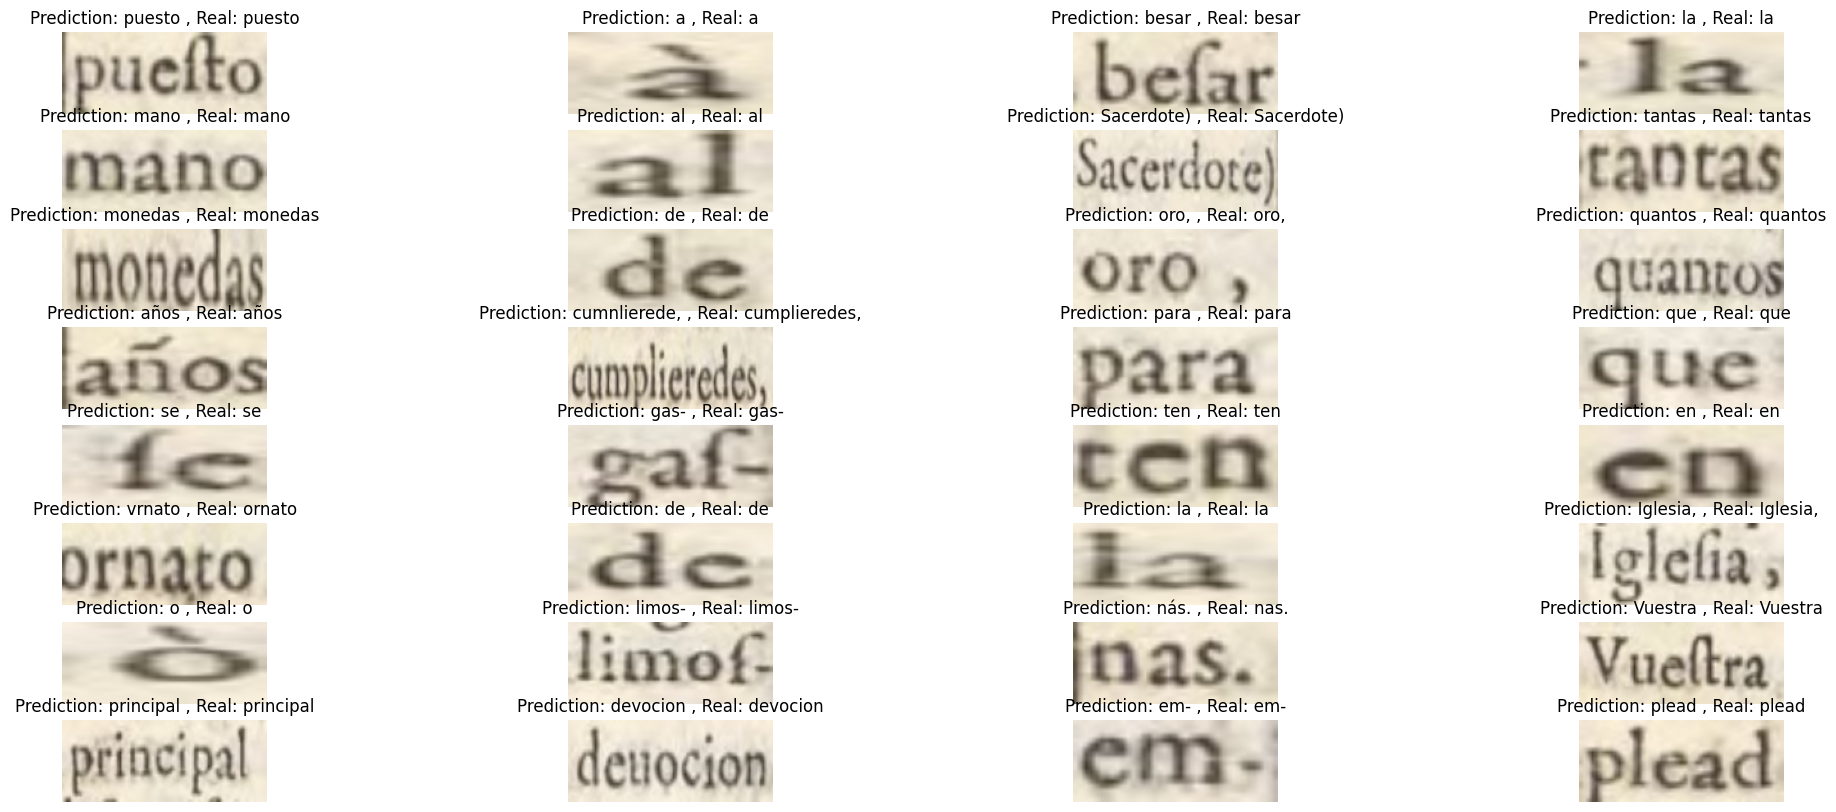

---------------------------32-------------------------------


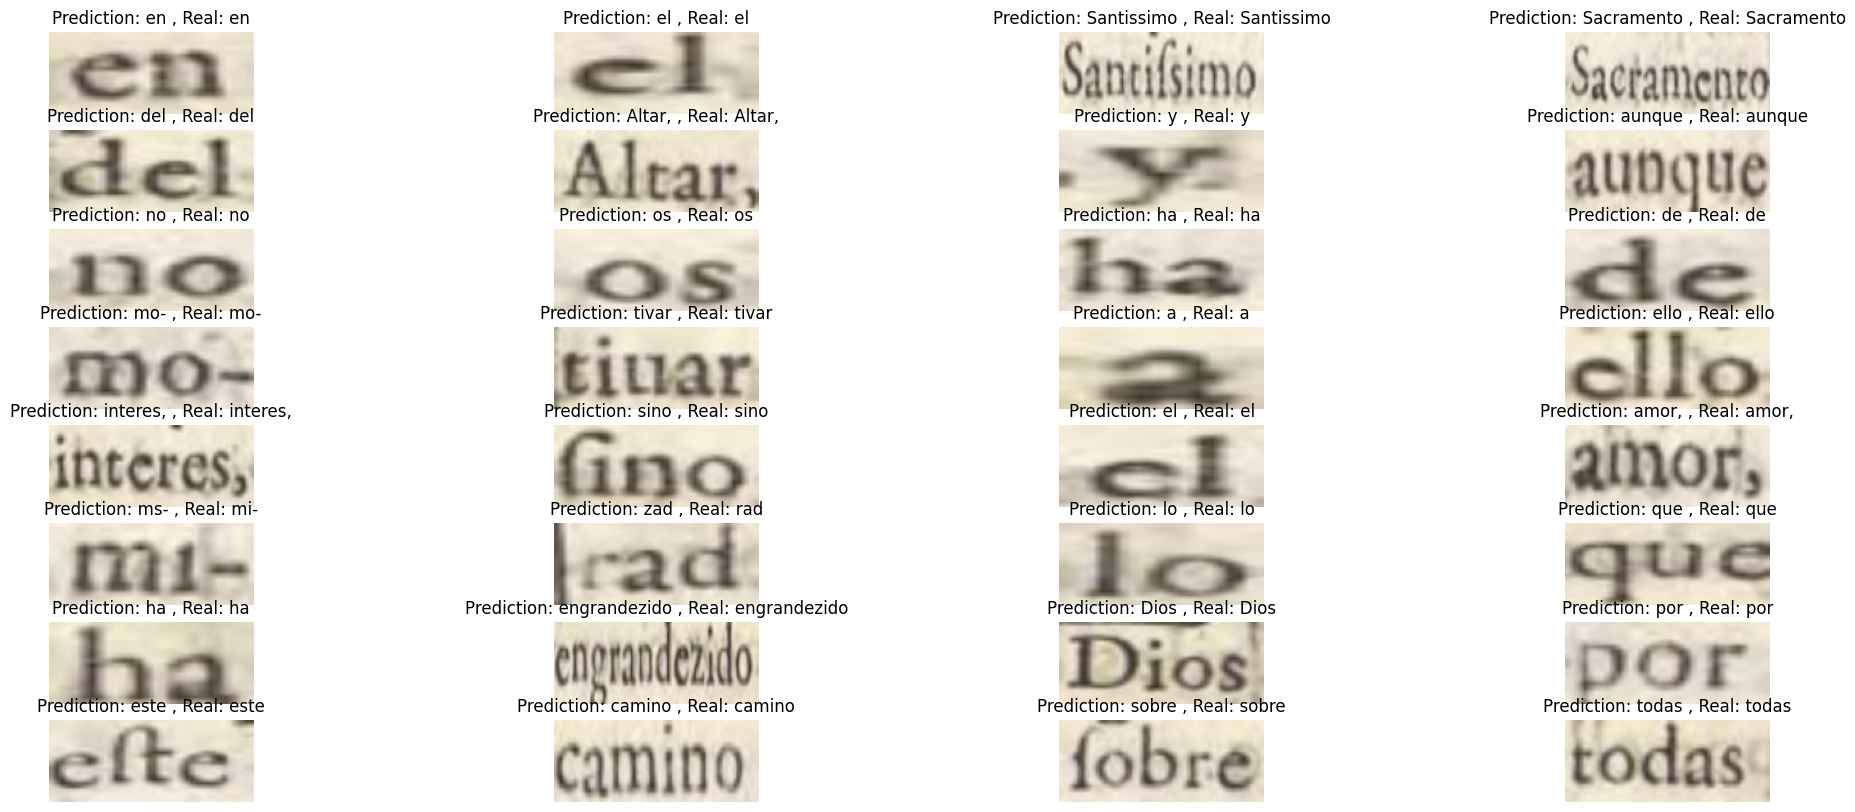

---------------------------32-------------------------------


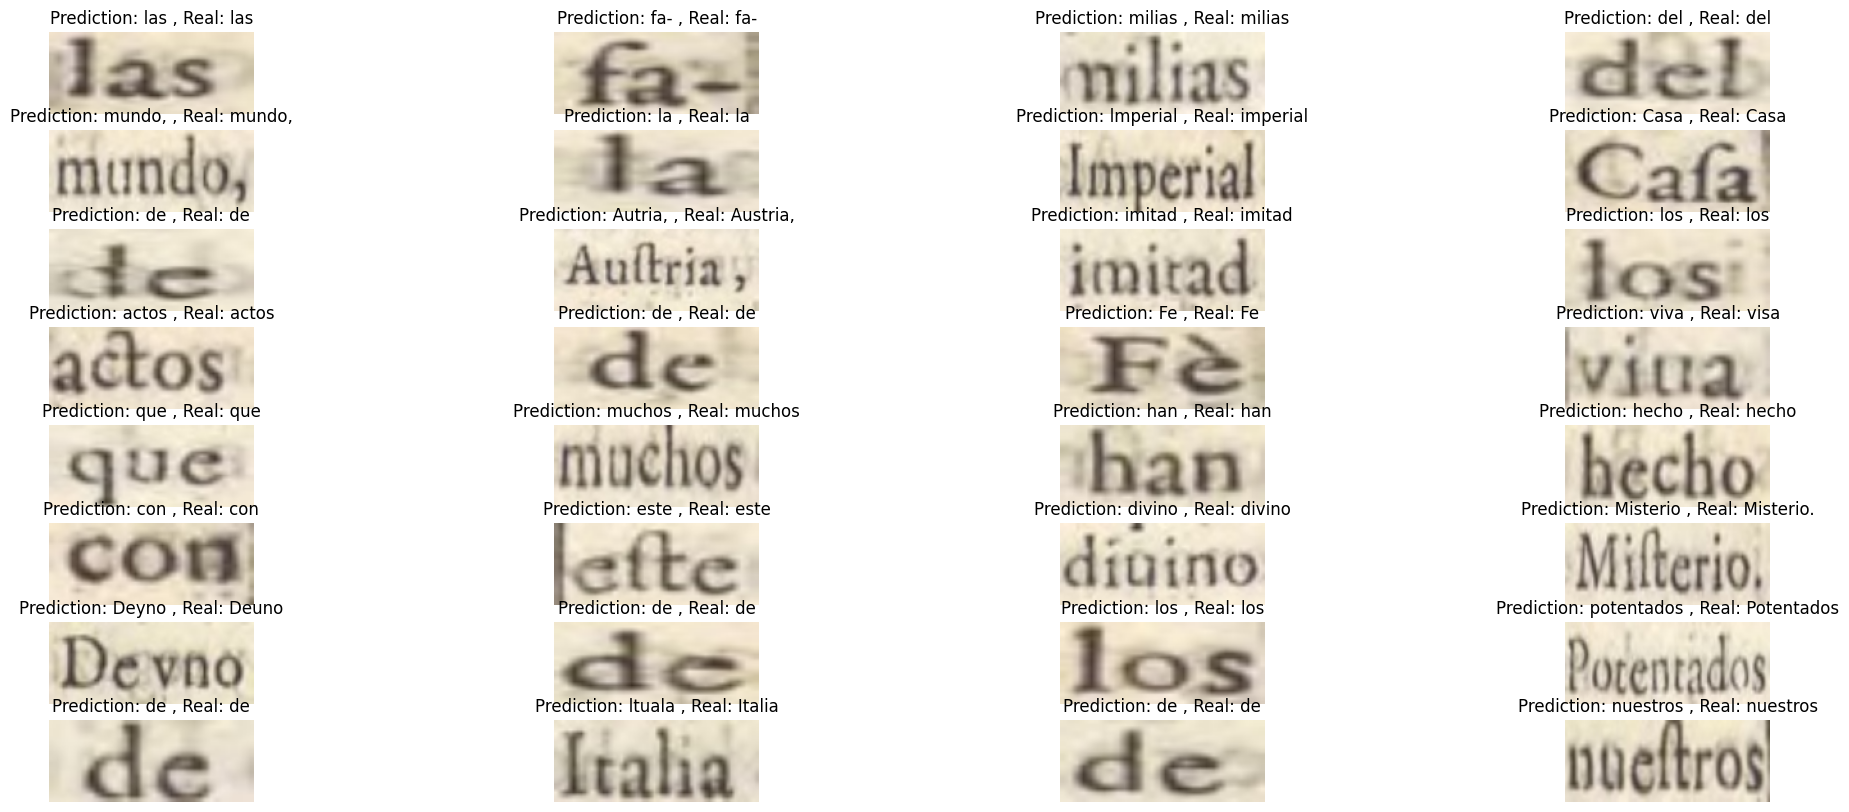

---------------------------32-------------------------------


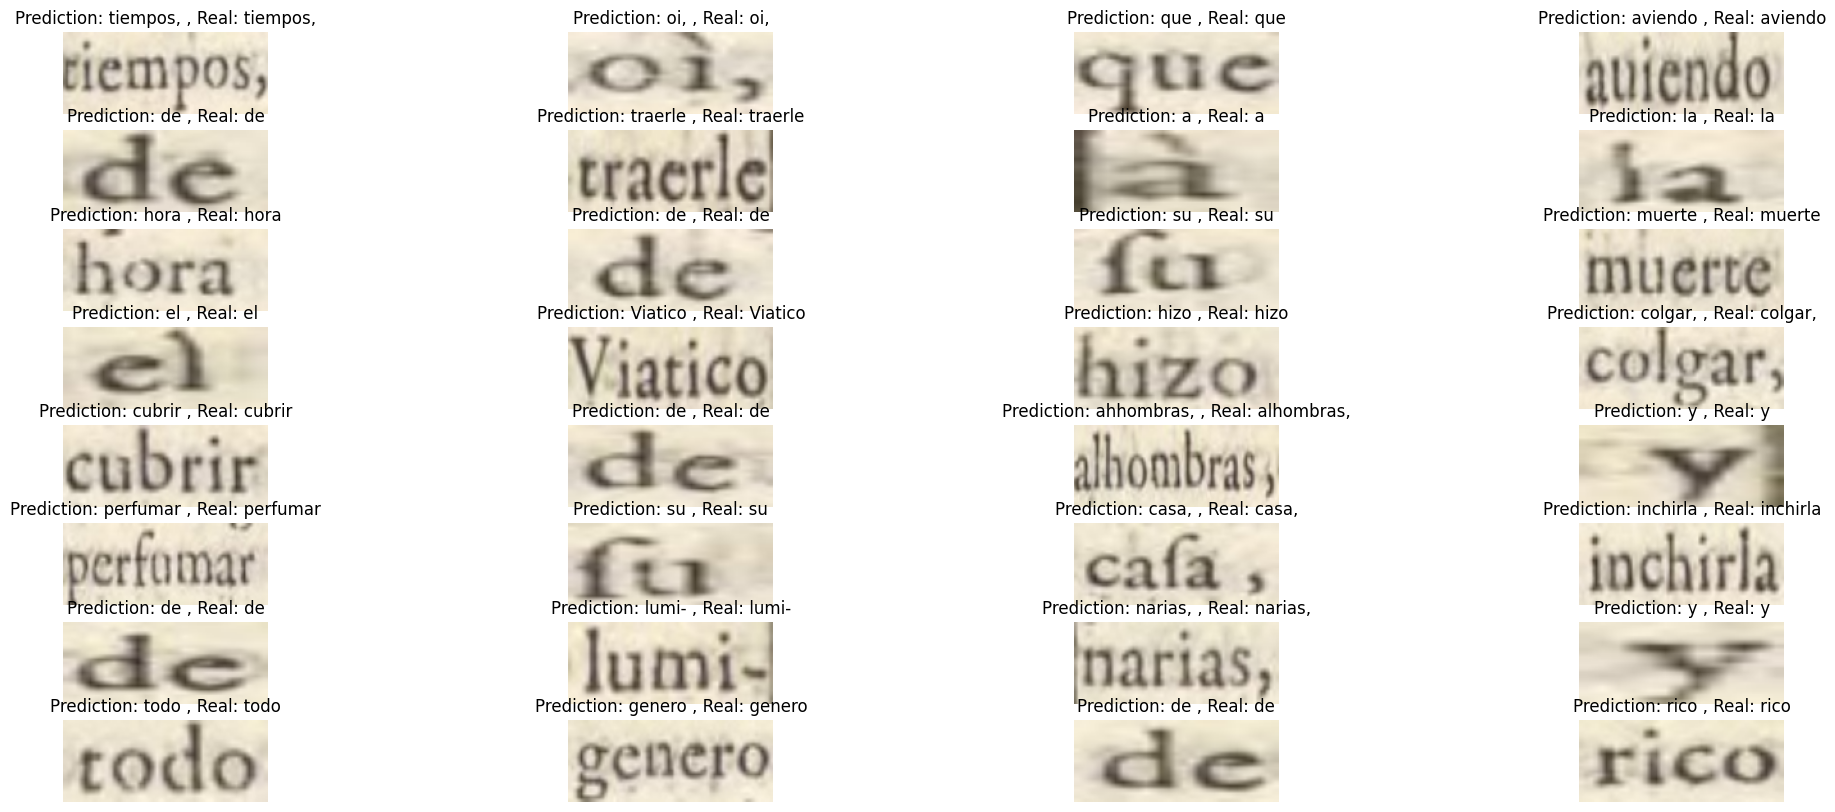

---------------------------32-------------------------------


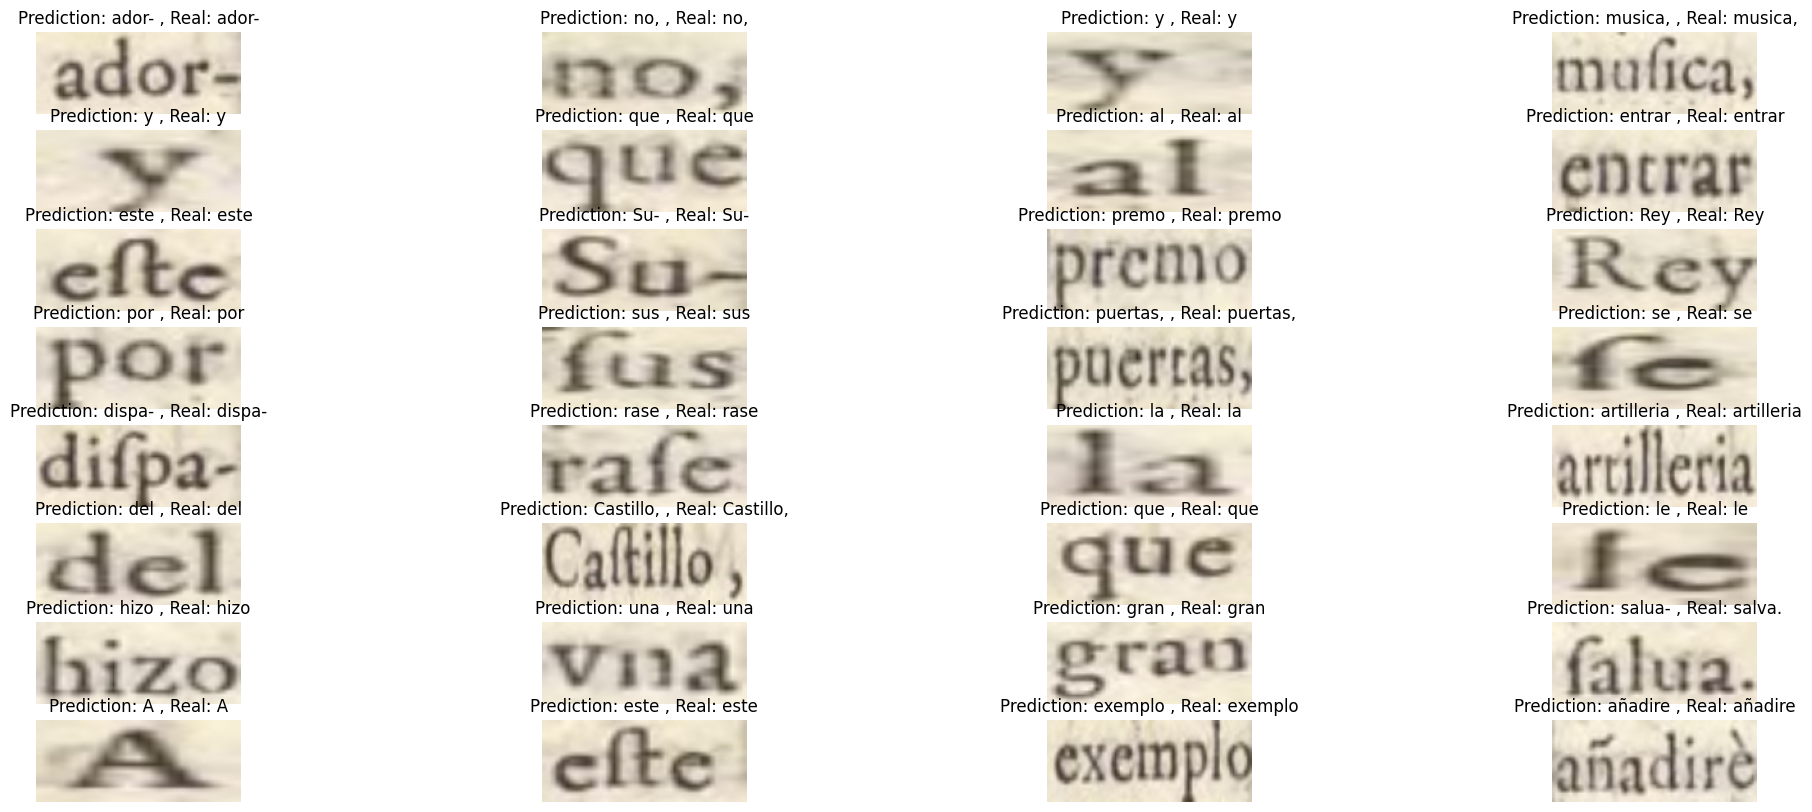

In [26]:
with torch.no_grad():
        for i, data in enumerate(val_loader):
            if i == 5:
                 break
            device = 'cuda' if next(crnn.parameters()).is_cuda else 'cpu'

            images, targets, target_lengths = [d.to(device) for d in data]

            logits = crnn(images)
            log_probs = torch.nn.functional.log_softmax(logits, dim=2)

            batch_size = images.size(0)

            preds = ctc_decode(log_probs, method="beam_search", beam_size=10)
            reals = targets.cpu().numpy().tolist()
            target_lengths = target_lengths.cpu().numpy().tolist()
            print(f"---------------------------{len(preds)}-------------------------------")
            _, ax = plt.subplots(8, 4, figsize=(25, 10))
            for k, (image, pred, real, target_length) in enumerate(zip(images, preds, reals, target_lengths)):
                img = (image*255).cpu().numpy().astype(np.uint8)
                real = real[0:target_length[0]]
                real=decode(real)
                pred=decode(pred)
                # print(f"prediction:{pred} , real:{real}")
                title = f"Prediction: {pred} , Real: {real}"
                img_tr = np.transpose(img, (1,2,0))
                ax[k // 4, k % 4].imshow(img_tr)
                ax[k // 4, k % 4].set_title(title)
                ax[k // 4, k % 4].axis("off")
            plt.show()
                
                

# Text Detection

In [27]:
import torch.nn.init as init
from collections import namedtuple
from torchvision import models
import time
from torch.autograd import Variable
# from torchvision.models.vgg import model_urls

In [28]:
import cv2
import numpy
import pytesseract
from pytesseract import image_to_string

In [29]:
def predict_boxes(img_path):
    img = cv2.imread(img_path)
    H,W=img.shape[0], img.shape[1]
    img = cv2.resize(img,(320, 512))
    rW=W/256
    rH=H/512
    b,g,r = cv2.split(img)
    # text detection network
    net = cv2.dnn.readNet('./frozen_east_text_detection.pb')
    blob = cv2.dnn.blobFromImage(img, 1.0, (img.shape[1],img.shape[0]), (b.mean(), g.mean(), r.mean()), swapRB=False, crop=False)
    outputLayers = []
    outputLayers.append("feature_fusion/Conv_7/Sigmoid")
    outputLayers.append("feature_fusion/concat_3")
    net.setInput(blob)
    output = net.forward(outputLayers)
    scores = output[0]
    geometry = output[1]

    (numRows, numCols) = scores.shape[2:4]
    rects = []
    confidences = []

    for y in range(0, numRows):
        scoresData = scores[0, 0, y]
        xData0 = geometry[0, 0, y]
        xData1 = geometry[0, 1, y]
        xData2 = geometry[0, 2, y]
        xData3 = geometry[0, 3, y]
        anglesData = geometry[0, 4, y]

        for x in range(0, numCols):
            # if our score does not have sufficient probability, ignore it
            if scoresData[x] < 0.1:
                continue

            # compute the offset factor as our resulting feature maps will
            # be 4x smaller than the input image
            (offsetX, offsetY) = (x * 4.0, y * 4.0)

            # extract the rotation angle for the prediction and then
            # compute the sin and cosine
            angle = anglesData[x]
            cos = np.cos(angle)
            sin = np.sin(angle)

            # use the geometry volume to derive the width and height of
            # the bounding box
            h = xData0[x] + xData2[x]
            w = xData1[x] + xData3[x]

            # compute both the starting and ending (x, y)-coordinates for
            # the text prediction bounding box
            endX = int(offsetX + (cos * xData1[x]) + (sin * xData2[x]))
            endY = int(offsetY - (sin * xData1[x]) + (cos * xData2[x]))
            startX = int(endX - w) 
            startY = int(endY - h)

            # add the bounding box coordinates and probability score to
            # our respective lists
            rects.append((startX, startY, endX, endY))
            confidences.append(scoresData[x])
    boxes = non_max_suppression(np.array(rects), probs=confidences, overlapThresh=0.4)
    # print(len(boxes))
    # print(img.shape)
    orig = img.copy()

    # orig = cv2.resize(orig,(320, 512))
    for i, (startX, startY, endX, endY) in enumerate(boxes):
        # scale the bounding box coordinates based on the respective
        # ratios
        startX = int(startX )
        startY = int(startY ) 
        endX = int(endX ) 
        endY = int(endY ) + 5
        # draw the bounding box on the image
        cv2.rectangle(orig, (startX, startY), (endX, endY), (0, 0, 255), 1)

    # show the output image
    image = cv2.cvtColor(orig, cv2.COLOR_BGR2RGB)
    plt.imshow(image)
    plt.show()
    
    return boxes
        

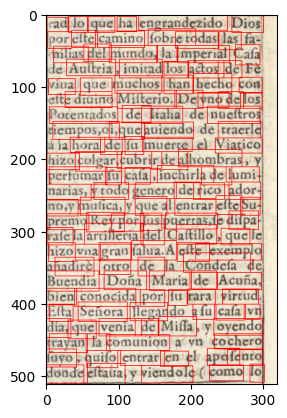

130


In [30]:
boxes = predict_boxes("./Data/p12_1.png")
print(len(boxes))

In [31]:
# sorting the boxes detected as we read the text from left to right
min_height=100
for box in boxes:
    height=box[3]-box[1]
    if height<min_height:
        min_height=height
# sort the text bixes based on the height
height_sort = sorted(boxes, key = lambda x: x[1])
rows=[]
check=0
row_no=0
for i, box in enumerate(height_sort):
    if i==0:
        check = box[1]
        row_no+=1
        rows.append([row_no,box])
        continue
    if box[1]>=check+min_height:
        row_no+=1
        check=box[1]
        rows.append([row_no, box])
        continue
    rows.append([row_no, box])
# cluster the text boxes belonging to a row
final_sort={}
idx=0
for i in rows:
    if i[0]>idx:
        idx=i[0]
        final_sort[idx]=[]
    final_sort[idx].append(i[1])
# keeping the text bixes detected as we read from left to right and top to bottom
final=[]
for index in final_sort.keys():
    l=final_sort[index]
    l=sorted(l, key = lambda x: x[0])
    for box in l:
        final.append(box)     

In [36]:
def recognize_text(img_path, boxes, file_name: None):
    img = cv2.imread(img_path)
    img = cv2.resize(img, (320,512))
    for i, (startX, startY, endX, endY) in enumerate(boxes):
        # print(startX, startY, endX, endY)
        if startX<0:
            startX=0
        if startY<0:
            startY=0
        cropped_img = img[startY:endY+5, startX:endX]
        cropped_img = cv2.cvtColor(cropped_img, cv2.COLOR_BGR2RGB)
        img_height = 64
        img_width = 160
        transform = transforms.Compose([
            transforms.ToPILImage(),
            transforms.Resize((img_height, img_width)),  # Resize image to a fixed size
            transforms.ToTensor(),          # Convert image to tensor
        ])
        image = transform(cropped_img)
        image = image.to(device)
        image = image.unsqueeze(0)
        logits = crnn(image)
        log_probs = torch.nn.functional.log_softmax(logits, dim=2)
        pred = ctc_decode(log_probs, method='beam_search', beam_size=10)
        # pred = pred.squeeze(0)
        # print(pred)
        pred = decode(pred[0])
        print(pred)
        # plt.imshow(cropped_img)
        # plt.show()
        # if i==10:
        #     break

In [37]:
recognize_text("./Data/p12_1.png", boxes=final, file_name=None)

ad
lo
que
ha
engrandeido
Dios
oor
este
camino
sobretr
etodas
las
nilias
del
mundo,
la
mperial
zasa
Austria
imitad
los
actos
de
ziua
que
muéhos
Pan
hecho
con
edivino
Misterio.
pes
uno,
ode
los
Potentados
de
ltuala
nuestros
iempos,oi
ique
aviendo
traerle
hora


de
su
muerte
Viatico
hizo
colgar,
cubrir
rdea)
atombras
verfumar
su
casa
jnchirla.
adel
lumi-
narias,
rtodo
genero
de,
rico
ador-
noy
nusica,
quea
entrar
este
Su-
premo
Reyp
Apor
sus
vuertass
dispa
rase
avissa
del
antillo
que
vizo
una
gran
salvaz
este
exemplo
ñadire-
otro
de
cd,
nuendia
poña
Maria
de
Acuña
bien
conocida
por
su
rara
virtud
sta
Señora
llegan
asu
casa
ynr
dia,
que
venia
de
Missa
oendo
rayan
lae
comunion
tochero
suyo
quiso
entrar
en
apose
sento
donde
estava
iendole
como
lo
